# CS 4650/7650 - Natural Language - HW - 1 
Georgia Tech, Summer 2025 (Instructor: Kartik Goyal)

Welcome to the first full programming assignment for CS 4650/7650! 

In this assignment, you will be implementing different deep learning models for text classification using the [20 Newsgroups](http://qwone.com/~jason/20Newsgroups/). It is esentially classifying news articles into different topics. This assignment will start with with data preprocessing techniques, implementing a baseline, and building up from there to more advanced model. It will cover basics of attention mechanism, something very central to modern NLP systems, and present you an opportunity to analyse different aspects of your training model.

This assignment will help you diver deeper into the world of Neural Networks and how to implement them for one application in Natural Language Processing. You are expected to have a good understanding of NumPy and PyTorch before starting this assignment.

- NumPy Quickstarter Guide: https://numpy.org/doc/stable/user/quickstart.html
- A good tutorial on PyTorch: https://www.youtube.com/watch?v=OIenNRt2bjg
- Detailed Documentation of PyTorch: https://pytorch.org/docs/stable/index.html
- Lecture Material on PyTorch and HuggingFace: https://github.com/neelabhsinha/cs7650-gatech-nlp-pytorch-huggingface-tutorial

DO NOT CHANGE the names of any of the files and contents outside the cells where you have to write code.

NOTE: DO NOT USE ANY OTHER EXTERNAL LIBRARIES FOR THIS ASSIGNMENT

<font color='red'> DEADLINE: July 21, 2025, 11:59 PM  </font><br>

The assignment is broken down into 6 Sections. The sections are as follows:

| Section | Part                                      | Points |
|---------|-------------------------------------------|--------|
| 1       | Loading and Preprocessing Data            | 7      |
| 2       | Neural Bag of Words (NBOW)                | 3      |
| 3       | Model Training (utilities for all models) | 15     |  
| 4       | Deep Averaging Networks (DANs)            | 8      |
| 5       | Attention-based Models                    | 30     |
| 6       | Perceptron and Hinge Losses               | 16     |
| 7       | Analysis                                  | 21     |
| 8       | Bonus: Improving Attention Models         | 10     |
| -       | Total                                     | 100 + 10 = 110     |


All the best and happy coding!

## 0. Setup

In [1]:
%load_ext autoreload
%autoreload 2

import sys

# Check what version of Python is running
print(sys.version)

3.11.13 (main, Jun  5 2025, 13:12:00) [GCC 11.2.0]


In [2]:
# export
import os

In [3]:
# folder_path = '/content/drive/My Drive/path/to/folder/HW0'
# the above is what folder path should look like the folder path if you execute in colab
folder_path = '.'

# Files in the folder -
os.listdir(folder_path)
os.chdir(folder_path)

In [4]:
# DO NOT CHANGE THIS CELL
# RUN THIS CELL ONLY IF RUNNING ON PACE-ICE 

# You can ignore this cell if you have already changed the symlink of .cache/ to a location in scratch folder


# override the huggingface cache path and nltk cache path
dirs = {
    "HF_HOME":"~/scratch/hf_cache",
    "TRITON_CACHE_DIR":"~/scratch/triton_cache",
    "TORCHINDUCTOR_CACHE_DIR":"~/scratch/inductor_cache",
    'NLTK_DATA':"~/scratch/nltk_data"
}

for name in dirs:
    d = dirs[name]
    path = os.path.expanduser(d)
    print(name)
    print(path)
    os.makedirs(path, exist_ok=True)
    # making sure the cache dirs are rwx for owner
    os.chmod(path, 0o700)
    os.environ[name] = path


HF_HOME
/home/jblevins32/scratch/hf_cache
TRITON_CACHE_DIR
/home/jblevins32/scratch/triton_cache
TORCHINDUCTOR_CACHE_DIR
/home/jblevins32/scratch/inductor_cache
NLTK_DATA
/home/jblevins32/scratch/nltk_data


In [5]:
# export
# Importing required libraries
# Do not change the libraries already imported or import additional libraries
import torch
import torch.nn as nn
import random
import numpy as np
from collections import Counter
import re
import html
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, RandomSampler, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [6]:
# export
# SOME UTILITY FUNCTIONS - DO NOT CHANGE
def save_checkpoint(model, model_name, loss_fn='ce'):
    file_path = os.path.join(os.getcwd(), 'model_weights', f'checkpoint_{model_name}_{loss_fn}.pt')
    os.makedirs(os.path.join(os.getcwd(), 'model_weights'), exist_ok=True)
    checkpoint = { # create a dictionary with all the state information
        'model_state_dict': model.state_dict()
    }
    torch.save(checkpoint, file_path)
    print(f"Checkpoint saved to {file_path}")

def load_checkpoint(model, model_name, loss_fn='ce', map_location='cpu'):
    file_path = os.path.join(os.getcwd(), 'model_weights', f'checkpoint_{model_name}_{loss_fn}.pt')
    checkpoint = torch.load(file_path, map_location=map_location) # load the checkpoint, ensure correct device
    model.load_state_dict(checkpoint['model_state_dict'])

In [7]:
# SOME UTILITY FUNCTIONS - DO NOT CHANGE
def plot_loss(train_loss_over_time, val_loss_over_time, model_name):
    epochs = range(1, len(train_loss_over_time) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss_over_time, color='red', label='Train Loss')
    plt.plot(epochs, val_loss_over_time, color='blue', label='Val Loss')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
#export
# Defining global constants - DO NOT CHANGE THESE VALUES (except batch size if you have memory issues)
RANDOM_SEED = 42
PADDING_VALUE = 0
UNK_VALUE     = 1
BATCH_SIZE = 128

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
device = torch.device('cuda' if torch.cuda.is_available() else('mps' if torch.backends.mps.is_available() else 'cpu'))

In [9]:
# This is how we select a GPU if it's available on your computer or in the Colab environment.
print('Device of execution - ', device)

Device of execution -  cuda


## 1. Preprocessing [7 points - Programming]

### 1.1. Data Cleaning Methods [0 points]
The following cell defines some methods to clean the dataset. Do not edit it, but feel free to take a look at some of the operations it's doing.


In [10]:
#export
# example code taken from fast-bert
# DO NOT CHANGE THIS CELL

def spec_add_spaces(t: str) -> str:
    "Add spaces around / and # in `t`. \n"
    return re.sub(r"([/#\n])", r" \1 ", t)

def rm_useless_spaces(t: str) -> str:
    "Remove multiple spaces in `t`."
    return re.sub(" {2,}", " ", t)

def replace_multi_newline(t: str) -> str:
    return re.sub(r"(\n(\s)*){2,}", "\n", t)

def fix_html(x: str) -> str:
    "List of replacements from html strings in `x`."
    re1 = re.compile(r"  +")
    x = (
        x.replace("#39;", "'")
        .replace("amp;", "&")
        .replace("#146;", "'")
        .replace("nbsp;", " ")
        .replace("#36;", "$")
        .replace("\\n", "\n")
        .replace("quot;", "'")
        .replace("<br />", "\n")
        .replace('\\"', '"')
        .replace(" @.@ ", ".")
        .replace(" @-@ ", "-")
        .replace(" @,@ ", ",")
        .replace("\\", " \\ ")
    )
    return re1.sub(" ", html.unescape(x))

def clean_text(input_text):
    text = fix_html(input_text)
    text = replace_multi_newline(text)
    text = spec_add_spaces(text)
    text = rm_useless_spaces(text)
    text = text.strip()
    return text

### 1.2. Data Cleaning and Tokenizing [0 points]

Clean the data using the methods above and tokenize it using NLTK

In [11]:
# DO NOT CHANGE THIS CELL
# Downloading the NLTK tokenizer
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
# Tokenizing the text
df = pd.read_csv("vocab.csv")
df["tokenized"] = df["data"].apply(lambda x: nltk.word_tokenize(clean_text(x.lower())))
func = lambda x: int(x) if x.isdigit() else x
df['target'] = df['target'].apply(func)
print(df.shape)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/jblevins32/scratch/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jblevins32/scratch/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


(16962, 4)


In [12]:
# DO NOT CHANGE THESE VALUES
# Divide the dataset into training and validation sets
# The following two lines are used to load the indices of the training and validation sets
train_indices = np.load("train_indices.npy")
val_indices = np.load("valid_indices.npy")
# The following two lines are used to select the training and validation sets from the dataframe based on the indices loaded above
train_data = df.iloc[train_indices].reset_index(drop=True)
val_data = df.iloc[val_indices].reset_index(drop=True)
func = lambda x: int(x) if str(x).isdigit() else x
val_data['target'] = val_data['target'].apply(func)
val_data = val_data.iloc[1:, :].reset_index(drop=True)

Here's what the dataset looks like. You can index into specific rows with pandas, and try to guess some of these yourself :). If you're unfamiliar with pandas, it's a extremely useful and popular library for data analysis and manipulation. You can find their documentation [here](https://pandas.pydata.org/docs/).

Pandas primary data structure is a DataFrame. The following cell will print out the basic information of this structure, including the labeled axes (both columns and rows) as well as show you what the first n (default=5) rows look like

In [13]:
# Print training and validation set heads
train_data.head()

,data,target,target_names,tokenized
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,9,rec.sport.baseball,"[from, :, mamatha, devineni, ratnam, <, mr47+,..."
1,From: glazier@isr.harvard.edu (Andrew Baker Gl...,6,misc.forsale,"[from, :, glazier, @, isr.harvard.edu, (, andr..."
2,From: simon@dcs.warwick.ac.uk (Simon Clippingd...,0,alt.atheism,"[from, :, simon, @, dcs.warwick.ac.uk, (, simo..."
3,From: keith@cco.caltech.edu (Keith Allan Schne...,0,alt.atheism,"[from, :, keith, @, cco.caltech.edu, (, keith,..."
4,From: mz@moscom.com (Matthew Zenkar)\\nSubject...,1,comp.graphics,"[from, :, mz, @, moscom.com, (, matthew, zenka..."


In [14]:
# DO NOT CHANGE THIS CELL
id2label = dict(zip(df['target'], df['target_names']))
id2label = {k: id2label[k] for k in id2label if isinstance(k, int)}
id2label = {k: id2label[k] for k in sorted(id2label)}
id2label

{0: 'alt.atheism',
 1: 'comp.graphics',
 2: 'comp.os.ms-windows.misc',
 3: 'comp.sys.ibm.pc.hardware',
 4: 'comp.sys.mac.hardware',
 5: 'comp.windows.x',
 6: 'misc.forsale',
 7: 'rec.autos',
 8: 'rec.motorcycles',
 9: 'rec.sport.baseball',
 10: 'rec.sport.hockey',
 11: 'sci.crypt',
 12: 'sci.electronics',
 13: 'sci.med',
 14: 'sci.space',
 15: 'soc.religion.christian',
 16: 'talk.politics.guns',
 17: 'talk.politics.mideast',
 18: 'talk.politics.misc',
 19: 'talk.religion.misc'}

This is a dictionary which maps ids to label names. It will be handy in the later part of the assignment.

### 1.3. Vocabulary Building [2 points - Programming]

Generate a vocabulary map for all the words in your dataset

Now that we've loaded this dataset, we need to create a vocab map for words, which will map tokens to numbers. This will be useful later, since torch PyTorch use tensors of sequences of numbers as inputs. **Go to the following cell, and fill out generate_vocab_map.**

In [52]:
# export

def generate_vocab_map(df, cutoff=2):
    """
    This method takes a dataframe and builds a vocabulary to unique number map.
    It uses the cutoff argument to remove rare words occurring <= cutoff times.
    "" and "UNK" are reserved tokens in our vocab that will be useful later. 
    You'll also find the Counter imported for you to be useful as well.
    
    Args:
        df (pandas.DataFrame) : The entire dataset this mapping is built from
        cutoff (int) : We exclude words from the vocab that appear less than or equal to cutoff
             
    Returns:
        vocab (dict[str] = int) : In vocab, each str is a unique token, and each dict[str] is a
            unique integer ID. Only elements that appear > cutoff times appear in vocab. 
        reversed_vocab (dict[int] = str) : A reversed version of vocab, which allows us to retrieve
            words given their unique integer ID. This map will allow us to "decode" integer 
            sequences we'll encode using vocab!
    """
    vocab = {"": PADDING_VALUE, "UNK": UNK_VALUE}
    count = Counter(vocab.keys())
    reversed_vocab = {}

    ## YOUR CODE STARTS HERE ##
    # hint: start by iterating over df["tokenized"]
    for tokens in df["tokenized"]:
        for token in tokens:
            if token not in vocab:
                count.update([token])
                if count[token] > cutoff:
                    vocab[token] = len(vocab)

    # Create the reversed vocabulary
    for item in vocab.items():
        reversed_vocab[item[1]] = item[0]

    ## YOUR CODE ENDS HERE ##

    return vocab, reversed_vocab

With the methods you have implemented above, you can now generate your dictionaries mapping from word tokens to IDs (and vice versa).

In [53]:
# DO NOT CHANGE THIS CELL
train_vocab, reverse_vocab = generate_vocab_map(train_data)

In [54]:
# Check Vocabulary Size - DO NOT CHANGE THIS VALUE
assert len(train_vocab) == 60233, f"Vocabulary is of incorrect size: {len(train_vocab)}"

# No error means you've passed the test!

### 1.4. Building a Dataset Class [2 points - Programming]

PyTorch has custom Dataset Classes that have very useful extensions, we want to turn our current pandas DataFrame into a subclass of Dataset so that we can iterate and sample through it for minibatch updates. **In the following cell, fill out the HeadlineDataset class.** Refer to PyTorch documentation on [Dataset Classes](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
for help.

In [289]:
#export

class HeadlineDataset(Dataset):
    """
    This class takes a Pandas DataFrame and wraps in a Torch Dataset.
    Read more about Torch Datasets here:
    https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    """
    def __init__(self, vocab, df, max_length=200):
        """
        Initialize the class with appropriate instance variables. In this method, we 
        STRONGLY recommend storing the dataframe itself as an instance variable, and 
        keeping this method very simple. Leave processing to __getitem__.
        
        Args:
            vocab (dict[str] = int) : In vocab, each str is a unique token, and each dict[str] is a
                unique integer ID. Only elements that appear > cutoff times appear in vocab. 
            df (pandas.DataFrame) : The entire dataset this mapping is built from
            max_length (int) : The max length of a headline we'll allow in our dataset.
            
        Returns:
            None
        """
        
        ## YOUR CODE STARTS HERE - initialize parameters ##

        self.vocab = vocab
        self.df = df
        self.max_length = max_length

        ## YOUR CODE ENDS HERE ##
    
    def __len__(self):
        """
        This method returns the length of the underlying dataframe,
        Args:
            None
        Returns:
            df_len (int) : The length of the underlying dataframe
        """

        df_len = None
        
        ## YOUR CODE STARTS HERE ##
        
        df_len = len(self.df)

        ## YOUR CODE ENDS HERE ##
        
        return df_len
    
    def __getitem__(self, index: int):
        """
        This method converts a dataframe row (row["tokenized"]) to an encoded torch LongTensor,
        using our vocab map created using generate_vocab_map. Restricts the encoded headline
        length to max_length.
        
        The purpose of this method is to convert the row - a list of words - into a corresponding
        list of numbers.
        
        i.e. using a map of {"hi": 2, "hello": 3, "UNK": 0}
        this list ["hi", "hello", "NOT_IN_DICT"] will turn into [2, 3, 0]
        
        Args:
            index (int) : The index of the dataframe we want to retrieve.
            
        Returns:
            tokenized_word_tensor (torch.LongTensor) : A 1D tensor of type Long, that has each
                token in the dataframe mapped to a number. These numbers are retrieved from the
                vocab_map we created in generate_vocab_map.
                
                IMPORTANT: If we filtered out the word because it's infrequent (and it doesn't
                exist in the vocab) we need to replace it w/ the UNK token
                
            curr_label (int) : Label index of the class between 0 to len(num_classes) - 1 representing which 
            class label does this data instance belong to
        """
        
        tokenized_word_tensor = []
        
        ## YOUR CODE STARTS HERE ##

        # Iterate through words to create tokenized_word_tensor
        for word in self.df.iloc[index]["tokenized"]:
            if word not in self.vocab:
                tokenized_word_tensor.append(self.vocab["UNK"])
            else:
                tokenized_word_tensor.append(self.vocab[word])

            if len(tokenized_word_tensor) >= self.max_length:
                break

        tokenized_word_tensor = torch.LongTensor(tokenized_word_tensor)
        curr_label = self.df.iloc[index]["target"]

        ## YOUR CODE ENDS HERE ##
        
        return tokenized_word_tensor, curr_label

In [290]:
# DO NOT CHANGE THIS CELL
train_dataset = HeadlineDataset(train_vocab, train_data)
val_dataset   = HeadlineDataset(train_vocab, val_data)

# Now that we're wrapping our dataframes in PyTorch datsets, we can make use of PyTorch Random Samplers, they'll define how our DataLoaders sample elements from the HeadlineDatasets
train_sampler = RandomSampler(train_dataset)
val_sampler   = RandomSampler(val_dataset)

In [291]:
# Check Dataset Lengths - DO NOT CHANGE THESE VALUES
assert len(train_dataset) == 15076, f"Training Dataset is of incorrect size {len(train_dataset)}"
assert len(val_dataset)   ==  1885, f"Validation Dataset is of incorrect size {len(val_dataset)}"

# No error means you've passed the test!

### 1.5. Finalizing our DataLoader [3 points - Programming]

We can now use PyTorch DataLoaders to batch our data for us. **In the following cell fill out collate_fn.** Refer to PyTorch documentation on [DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for help. Apply padding and other post-processing required here.

In [297]:
#export

def collate_fn(batch, padding_value=PADDING_VALUE):
    """
    This function is passed as a parameter to Torch DataSampler. collate_fn collects
    batched rows, in the form of tuples, from a DataLoader and applies some final
    pre-processing.
    
    Objective:
    In our case, we need to take the batched input array of 1D tokenized_word_tensors,
    and create a 2D tensor that's padded to be the max length from all our tokenized_word_tensors
    in a batch. We're moving from a Python array of tuples, to a padded 2D tensor.
    
    *HINT*: you're allowed to use torch.nn.utils.rnn.pad_sequence (ALREADY IMPORTED)
    
    Finally, you can read more about collate_fn here: https://pytorch.org/docs/stable/data.html
    
    :param batch: PythonArray[tuple(tokenized_word_tensor: 1D Torch.LongTensor, curr_label: int)] of length BATCH_SIZE
    :param padding_value: int
    
    :return padded_tokens: 2D LongTensor of shape (BATCH_SIZE, max len of all tokenized_word_tensor))
    :return y_labels: 1D FloatTensor of shape (BATCH_SIZE)
    """
        
    ## YOUR CODE STARTS HERE - take the input and target from batch, pad the tokens, convert batches to tensor ##

    # Unzip the batch
    token_tensors, labels = zip(*batch)

    # Pad the token tensors to the maximum length in the batch
    padded_tokens = torch.nn.utils.rnn.pad_sequence(token_tensors, batch_first=True, padding_value=padding_value)
    
    y_labels = torch.tensor(labels, dtype=torch.long)  # Convert labels to a tensor of type long


    ## YOUR CODE ENDS HERE ##
    
    return padded_tokens, y_labels

In [298]:
# DO NOT CHANGE THIS CELL
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn)
val_iterator   = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, collate_fn=collate_fn)

In [301]:
# Use this to test your collate_fn implementation.
# You can look at the shapes of x and y or put print statements in collate_fn while running this snippet
# DO NOT CHANGE THIS CELL

for x, y in train_iterator:
    print(f'x: {x.shape}')
    print(f'y: {y.shape}')
    break

x: torch.Size([128, 200])
y: torch.Size([128])


## 2. Neural Bag of Words (NBOW) [3 pts - Programming]
Let's move to modeling, now that we have dataset iterators that batch our data for us. The first model is a simple model called NBOW-RAND.

In the following code block, you'll build a feed-forward neural network implementing a neural bag-of-words baseline, NBOW-RAND, described in section 2.1 of [this paper](https://www.aclweb.org/anthology/P15-1162.pdf). You'll find [this](https://pytorch.org/docs/stable/nn.html) page useful for understanding the different layers and [this](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html) page useful for how to put them into action.

The core idea behind this baseline is that after we embed each word for a document, we average the embeddings to produce a single vector that hopefully captures some general information spread across the sequence of embeddings. This means we first turn each document of length *n* into a matrix of *nxd*, where *d* is the dimension of the embedding. Then we average this matrix to produce a vector of length *d*, summarizing the contents of the document and proceed with the rest of the network.

While you're working through this implementation, keep in mind how the dimensions change and what each axes represents, as documents will be passed in as minibatches requiring careful selection of which axes you apply certain operations too. Stick to only the architecture described in the instructions below, do not add additional layers, this will impact the validity of local checks.

Refer to the following equation on how to define NBOW -


$$ h_{avg} = \frac{1}{n} \sum_t emb(x_t) $$

The probability of a data instance belonging to class $y_i$ is given by:

$$ p(y|x) = softmax(w^T h_{avg}) $$

where $w \in R^d$ is a parameter vector.

*HINT*: In the forward step, the BATCH_SIZE is the first dimension.

*Hint*: Make sure to handle the case where the input contains pad tokens. We don't want to consider them in our average.

#### 2.1. Define the NBOW model class [3 points]

In [302]:
#export

class NBOW(nn.Module):
    # Instantiate layers for your model-
    #
    # Your model architecture will be a feed-forward neural network.
    #
    # You'll need 3 nn.Modules:
    # 1. An embeddings layer (see nn.Embedding)
    # 2. A linear layer (see nn.Linear)
    #
    # HINT: In the forward step, the BATCH_SIZE is the first dimension.
    #
    def __init__(self, vocab_size, embedding_dim, num_classes=20):
        super().__init__()
        ## YOUR CODE STARTS HERE ##

        # batch size x vocab size x embedding_dim x num_classes
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, num_classes)

        ## YOUR CODE ENDS HERE ##

    # Complete the forward pass of the model.
    #
    # Use the output of the embedding layer to create
    # the average vector, which will be input into the
    # linear layer.
    #   
    # args:
    # x - 2D LongTensor of shape (BATCH_SIZE, max len of all tokenized_word_tensor))
    #     This is the same output that comes out of the collate_fn function you completed
    def forward(self, x):
        ## Hint: Make sure to handle the case where x contains pad tokens. We don't want to consider them in our average.
        ## YOUR CODE STARTS HERE ##
        # print(x.shape)
        avg = self.get_h_avg(x)
        out = self.linear(avg)
        return out

        ## YOUR CODE ENDS HERE ##
    
    def get_embeddings(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        
        return self.embedding(x)
        
        ### YOUR CODE ENDS HERE ###
    
    def set_embedding_weight(self, weight):
        '''
        This function sets the embedding weights to the input weight. Ensure you aren't recording gradients for this.
        Hint: Refer to nn.Parameter to do this.
        Args:
            weight: torch.tensor of shape (vocab_size, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        with torch.no_grad():
            self.embedding.weight = nn.Parameter(weight, requires_grad=False)

        ### YOUR CODE ENDS HERE ###

    def get_h_avg(self, x):
        '''
        This function returns the average of the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        embeddings = self.get_embeddings(x)

        mask = (x!= PADDING_VALUE)

        # Count the number of non-padding tokens in each sequence for averaging later
        num_non_pads = mask.sum(dim=1).unsqueeze(-1)

        # Apply the mask to the embeddings
        embeddings = embeddings * mask.unsqueeze(-1) 

        return embeddings.sum(dim=1)/num_non_pads # gives batch_size x 1

        ### YOUR CODE ENDS HERE ###

In [303]:
# local test for sanity:
# DO NOT CHANGE THIS CELL

def nbow_test_local():
    embedding_dim = 10
    vocab_size = 5
    model = NBOW(vocab_size=vocab_size, embedding_dim=embedding_dim)
    for _, module in model.named_parameters():
        if hasattr(module, "data"):
            nn.init.constant_(module, 0.1)
    input = torch.arange(12).reshape(2,6) % vocab_size
    expected_result = torch.tensor(
        [[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000]]
    )
    with torch.no_grad():
        local_result = model(input)
    if torch.allclose(expected_result, local_result, rtol=0.001):
        print("Passed local check")
    else:
        print(f"Test failed, expected value was\n{expected_result}\nbut you got:\n{local_result}")

def nbow_test_local_embeddings():
    embedding_dim = 3
    vocab_size = 5
    model = NBOW(embedding_dim=embedding_dim, vocab_size=vocab_size)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    embeddings = model.get_embeddings(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_embeddings = torch.tensor([[[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.2400, 0.2600, 0.2800],
                                        [0.0600, 0.0800, 0.1000]],

                                        [[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.0000, 0.0200, 0.0400],
                                        [0.0000, 0.0200, 0.0400]]])
    if torch.allclose(embeddings, correct_embeddings, rtol=0.001):
        print("Passed local embedding test")
    else:
        print(f"Embedding Test failed, expected value was\n{correct_embeddings}\nbut you got:\n{embeddings}")
def nbow_test_local_h_avg():
    embedding_dim = 3
    vocab_size = 5
    model = NBOW(embedding_dim=embedding_dim, vocab_size=vocab_size)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    h_avg = model.get_h_avg(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_h_avg = torch.tensor([[0.1320, 0.1520, 0.1720],
                                  [0.1200, 0.1400, 0.1600]])
    if torch.allclose(h_avg, correct_h_avg, rtol=0.001):
        print("Passed local h_avg test")
    else:
        print(f"h_avg Test failed, expected value was\n{correct_h_avg}\nbut you got:\n{h_avg}")
nbow_test_local()
nbow_test_local_embeddings()
nbow_test_local_h_avg()

Test failed, expected value was
tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000]])
but you got:
tensor([[0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
         0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
         0.2000, 0.2000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
         0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
         0.2000, 0.2000]])
Passed local embedding test
Passed local h_avg test


## 3. Model Training [12 points - Programming + 3 points - Non-programming]

Training a PyTorch model involves several key components:

- **Training Loop**: This is the process where the model learns from the training data. In each iteration, the model processes the input data, makes predictions, calculates the loss, and updates its weights using backpropagation.
- **Validation Loop**: Performed after the training loop, this evaluates the model on a separate dataset (validation data) to check its performance. It helps in detecting overfitting.
- **Optimizer**: This is an algorithm that updates the model's weights during training. Common optimizers include SGD, Adam, etc.
- **Criterion (Loss Function)**: This measures how well the model is performing. It calculates the difference between the model's predictions and the actual data. Common loss functions include Mean Squared Error for regression tasks and Cross Entropy Loss for classification.

During training, the optimizer uses the gradient of the loss function to adjust the model's parameters. The model's performance is evaluated periodically on the validation set to monitor its generalization capability. This process continues for a specified number of epochs or until the model achieves a desired level of accuracy.

*Note - In the following code cells (of this section), the above components will be defined. These functions/objects will be used to train and evaluate all your models in this assignment. So, make sure to implement these in a generic way, so that they can be used for all the models.*


### 3.0. Evaluation Metrics [0 points]

Accuracy is a measure used to evaluate classification models, representing the ratio of correctly predicted observations to the total observations. It's simple and intuitive but may not be suitable for imbalanced datasets, as it can be misleading if the class distribution is skewed.

The F1-score, on the other hand, combines precision and recall into a single number. It is particularly useful when dealing with imbalanced datasets or when the cost of false positives and false negatives varies. F1-score provides a better measure of the incorrectly classified cases than the Accuracy Metric. It's calculated as the harmonic mean of precision and recall, thus balancing the two aspects of model performance.

You can read about the terms mentioned above here: https://scikit-learn.org/stable/modules/model_evaluation.html

For this assignment, we are already defining the above metrics for you to use in your implementation

In [304]:
#export
# DO NOT CHANGE THIS CELL
def get_accuracy_and_f1_score(y_true, y_predicted):
    """
    This function takes in two numpy arrays and computes the accuracy and F1 score
    between them. You can use the imported sklearn functions to do this.
    
    Args:
        y_true (list) : A 1D numpy array of ground truth labels
        y_predicted (list) : A 1D numpy array of predicted labels
        
    Returns:
        accuracy (float) : The accuracy of the predictions
        f1_score (float) : The F1 score of the predictions
    """
    
    # Get the accuracy
    accuracy = accuracy_score(y_true, y_predicted)
    
    # Get the F1 score
    f1 = f1_score(y_true, y_predicted, average='macro')
    
    return accuracy, f1


In [305]:
# DO NOT CHANGE THIS CELL
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=90)
    plt.show()

### 3.1. Criterion [2 points - Programming]

Criterion in PyTorch, refers to the loss function used to evaluate the model's performance. It quantifies how far off the model's predictions are from the actual target values

In PyTorch, **nn.CrossEntropyLoss()** is used for classification tasks. It first does a softmax on the scores, and then calculates the negative log likelihood. This is why you don't need to do sotmax in the model, you can return the scores. In the cell below, implement this.

In [255]:
#export

def get_criterion(loss_type='ce'):
    
    ## YOUR CODE STARTS HERE ##

    criterion = nn.CrossEntropyLoss()

    ## YOUR CODE ENDS HERE ##
    
    return criterion

### 3.2. Optimizer [2 points - Programming]

In PyTorch, an optimizer is a tool that updates the weights of the neural network to minimize the loss. Among these, Adam (Adaptive Moment Estimation) is a widely-used optimizer. Adam combines the best properties of the AdaGrad and RMSProp algorithms to handle sparse gradients on noisy problems. It's known for its effectiveness in deep learning models, especially where large datasets and high-dimensional spaces are involved. Adam adjusts the learning rate during training, making it efficient and effective across a wide range of tasks and model architectures.

In the cell below, define your optimizer. We recommend using Adam, but you are free to experiment with other optimizers as well.

The following function takes a model and learning rate value as input, and defines an optimizer for that model's parameters with that learning rate.

*HINT: model.parameters() can give you all the parameters of a PyTorch model*

In [256]:
#export
def get_optimizer(model, learning_rate):
    """
    This function takes a model and a learning rate, and returns an optimizer.
    Feel free to experiment with different optimizers.
    """
    
    ## YOUR CODE STARTS HERE ##

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    ## YOUR CODE ENDS HERE ##
    
    return optimizer

### 3.3. Training Loop [3 points - Programming]

The training loop function in PyTorch is a critical component where the actual learning from data occurs. It typically involves iterating over the training dataset, feeding the data to the model, computing the loss (difference between the predictions and true values), and updating the model's weights.

Creating a training loop involves several steps:

1. Iterate Over Dataset: Loop through the training dataset, often in mini-batches.
2. Forward Pass: Feed the input data to the model to get predictions.
3. Compute Loss: Calculate the loss using a loss function.
4. Backward Pass: Perform backpropagation by calling loss.backward(), which computes the gradient of the loss function with respect to each weight.
5. Update Weights: Use an optimizer (like SGD or Adam) to adjust the weights based on the gradients calculated.
6. Zero the Gradients: Reset the gradients to zero after each mini-batch to prevent accumulation of gradients from multiple passes.

This loop repeats for a specified number of epochs or until a certain level of accuracy or loss is achieved.

In the end, return the mean loss over all samples for this particular iteration

In [242]:
#export
def train_loop(model, criterion, optimizer, iterator, epoch, save_every=10):
    """
    This function is used to train a model for one epoch.
    :param model: The model to be trained
    :param criterion: The loss function
    :param optim: The optimizer
    :param iterator: The training data iterator
    :return: The average loss for this epoch
    """
    model.train() # Is used to put the model in training mode
    total_loss = 0
    for x, y in tqdm(iterator, total=len(iterator), desc="Training Model"):
        ### YOUR CODE STARTS HERE ###

        out = model(x.to(device))
        loss = criterion(out, y.to(device))
        optimizer.zero_grad()  # Zero the gradients before backward pass
        loss.backward()  # Backward pass to compute gradients
        optimizer.step()  # Update the model parameters
        total_loss += loss.item()
        
        ### YOUR CODE ENDS HERE ###

    average_loss = total_loss / len(iterator)
    return average_loss

### 3.4. Validation Loop [3 points - Programming]

The validation loop in PyTorch is where the model's performance is evaluated on a dataset different from the one used for training. It does not involve updating the model's weights, focusing instead on assessing how well the model generalizes to new data. Here's how it typically works:

1. Iterate Over Validation Dataset: Loop through the validation dataset, usually in mini-batches, without the need for shuffling as in the training loop.
2. Forward Pass: Feed the input data to the model to obtain predictions.
3. Compute Loss: Calculate the loss (e.g., Cross-Entropy, Mean Squared Error) to assess the performance on the validation dataset.
4. Calculate Metrics: Besides loss, other performance metrics like accuracy, F1 score, etc., are computed to evaluate model performance.

Note: No Backpropagation: Unlike the training loop, there is no backward pass or weight updates.

The validation loop is crucial for monitoring overfitting and tuning hyperparameters. It provides insight into how the model is likely to perform on unseen data.

In [244]:
# export
def val_loop(model, criterion, iterator):
    """
    This function is used to evaluate a model on the validation set.
    :param model: The model to be evaluated
    :param iterator: The validation data iterator
    :return: true: a Python boolean array of all the ground truth values
             pred: a Python boolean array of all model predictions.
            average_loss: The average loss over the validation set
    """
    
    true, pred = [], []
    total_loss = 0
    model.eval()
    for x, y in tqdm(iterator, total=len(iterator), desc="Evaluating Model"):
    ### YOUR CODE STARTS HERE ###
        
        out = model(x.to(device))
        loss = criterion(out, y.to(device))
        total_loss += loss.item()

        true.extend(y.cpu().numpy())
        pred.extend(torch.argmax(out, dim=1).cpu().numpy())

    ### YOUR CODE ENDS HERE ###
    average_loss = total_loss / len(iterator)
    return true, pred, average_loss

### 3.5. Training NBOW [3 points - Non-programming]
Assign and tune the below hyperparameters to optimize your model. Make sure that the output graph of the cell where training happens is clear in your submission.

In [249]:
#export
# Assigning hyperparameters and training parameters
# Experiment with different values for these hyperparaters to optimize your model's performance
def get_hyperparams_nbow():
  ### your hyper parameters
  learning_rate = 0.001
  epochs = 100
  embedding_dim = 64
  ### 
  return learning_rate, epochs, embedding_dim

Since the NBOW model is rather basic, assuming you haven't added any additional layers, there's really only one hyperparameter for the model architecture: the size of the embedding dimension.

The vocab_size parameter here is based on the number of unique words kept in the vocab after removing those occurring too infrequently, so this is determined by our dataset and is in turn not a true hyperparameter (though the cutoff we used previously might be). The embedding_dim parameter dictates what size vector each word can be embedded as.

A special note concerning the model initialization: We're specifically sending the model to the device set in Part 1, to speed up training if the GPU is available. **Be aware**, you'll have to ensure other tensors are on the same device inside your training and validation loops.

In [232]:
# export
def get_nbow_model(vocab_size, embedding_dim):
    """
    This function returns an instance of the NBOW model.
    """
    model = None
    # Define a model and return
    # YOUR CODE STARTS HERE
    
    model = NBOW(vocab_size=vocab_size, embedding_dim=embedding_dim)
    
    # YOUR CODE ENDS HERE
    return model

In [251]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
criterion = get_criterion()
optimizer = get_optimizer(nbow_model, learning_rate)
train_loss_over_time_nbow = []
val_loss_over_time_nbow = []
for epoch in range(epochs):
    train_loss = train_loop(nbow_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")
    train_loss_over_time_nbow.append(train_loss)
    val_loss_over_time_nbow.append(val_loss)
save_checkpoint(nbow_model, 'nbow')

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 65.63it/s]


Epoch 1 -- Train_Loss: 2.9675724566993065 -- Val_Loss: 2.929689121246338 -- Val_Accuracy: 0.14164456233421752 -- Val_F1: 0.10419242488590505


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 70.15it/s]


Epoch 2 -- Train_Loss: 2.885343876935668 -- Val_Loss: 2.8375008583068846 -- Val_Accuracy: 0.21061007957559683 -- Val_F1: 0.15967011258318436


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 66.56it/s]


Epoch 3 -- Train_Loss: 2.7682530859769403 -- Val_Loss: 2.7073963483174643 -- Val_Accuracy: 0.27692307692307694 -- Val_F1: 0.23794730149727067


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 64.45it/s]


Epoch 4 -- Train_Loss: 2.616403680736736 -- Val_Loss: 2.551301622390747 -- Val_Accuracy: 0.33156498673740054 -- Val_F1: 0.28941078181658264


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 67.06it/s]


Epoch 5 -- Train_Loss: 2.441908458531913 -- Val_Loss: 2.378230826059977 -- Val_Accuracy: 0.4042440318302387 -- Val_F1: 0.36753609647383767


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 68.07it/s]


Epoch 6 -- Train_Loss: 2.249844276298911 -- Val_Loss: 2.1958418528238934 -- Val_Accuracy: 0.48222811671087534 -- Val_F1: 0.4447312391203898


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 51.93it/s]


Epoch 7 -- Train_Loss: 2.0482401676097157 -- Val_Loss: 2.0125857671101888 -- Val_Accuracy: 0.5474801061007958 -- Val_F1: 0.5153502583055486


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 71.22it/s]


Epoch 8 -- Train_Loss: 1.8463206826630285 -- Val_Loss: 1.8335185766220092 -- Val_Accuracy: 0.6005305039787798 -- Val_F1: 0.569567002966069


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 48.22it/s]


Epoch 9 -- Train_Loss: 1.6516920712034582 -- Val_Loss: 1.662993359565735 -- Val_Accuracy: 0.6525198938992043 -- Val_F1: 0.6230832322192226


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 53.00it/s]


Epoch 10 -- Train_Loss: 1.4713314569602578 -- Val_Loss: 1.5087120850880942 -- Val_Accuracy: 0.6981432360742705 -- Val_F1: 0.6714857906181774


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 65.19it/s]


Epoch 11 -- Train_Loss: 1.307404119079396 -- Val_Loss: 1.3708706061045328 -- Val_Accuracy: 0.729973474801061 -- Val_F1: 0.7068111080719259


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 63.01it/s]


Epoch 12 -- Train_Loss: 1.161572884199983 -- Val_Loss: 1.2501374324162802 -- Val_Accuracy: 0.7549071618037135 -- Val_F1: 0.735649472265341


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 59.13it/s]


Epoch 13 -- Train_Loss: 1.0334912846654147 -- Val_Loss: 1.1419164737065632 -- Val_Accuracy: 0.7660477453580902 -- Val_F1: 0.7472453803360689


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 67.32it/s]


Epoch 14 -- Train_Loss: 0.9213500088554317 -- Val_Loss: 1.0457714478174844 -- Val_Accuracy: 0.7846153846153846 -- Val_F1: 0.7712352412347583


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.79it/s]


Epoch 15 -- Train_Loss: 0.8230046594547014 -- Val_Loss: 0.9620601614316304 -- Val_Accuracy: 0.8 -- Val_F1: 0.7878635510671155


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 66.42it/s]


Epoch 16 -- Train_Loss: 0.7377353588403281 -- Val_Loss: 0.8932492772738139 -- Val_Accuracy: 0.8122015915119364 -- Val_F1: 0.8023807323339796


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 65.27it/s]


Epoch 17 -- Train_Loss: 0.6632380662328106 -- Val_Loss: 0.8337235490481059 -- Val_Accuracy: 0.8222811671087533 -- Val_F1: 0.8131099445645124


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 65.33it/s]


Epoch 18 -- Train_Loss: 0.5980646734015417 -- Val_Loss: 0.7762093583742777 -- Val_Accuracy: 0.8339522546419098 -- Val_F1: 0.8254617698232876


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.09it/s]


Epoch 19 -- Train_Loss: 0.54107143464735 -- Val_Loss: 0.725298281510671 -- Val_Accuracy: 0.839787798408488 -- Val_F1: 0.8313997148083783


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 65.66it/s]


Epoch 20 -- Train_Loss: 0.49084832430896114 -- Val_Loss: 0.6848001837730407 -- Val_Accuracy: 0.8493368700265252 -- Val_F1: 0.8408681364573358


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 65.72it/s]


Epoch 21 -- Train_Loss: 0.4462441847486011 -- Val_Loss: 0.6472437461217244 -- Val_Accuracy: 0.8583554376657825 -- Val_F1: 0.8509325617254886


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 57.48it/s]


Epoch 22 -- Train_Loss: 0.4065625950441522 -- Val_Loss: 0.6133125960826874 -- Val_Accuracy: 0.8625994694960212 -- Val_F1: 0.8558385756024718


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.58it/s]


Epoch 23 -- Train_Loss: 0.3716319008903988 -- Val_Loss: 0.5866420865058899 -- Val_Accuracy: 0.8710875331564987 -- Val_F1: 0.8645126084875875


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 58.93it/s]


Epoch 24 -- Train_Loss: 0.3401546819230257 -- Val_Loss: 0.5610975543657939 -- Val_Accuracy: 0.8732095490716181 -- Val_F1: 0.8656123955865551


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.48it/s]


Epoch 25 -- Train_Loss: 0.31183741380602625 -- Val_Loss: 0.5373126844565074 -- Val_Accuracy: 0.8748010610079575 -- Val_F1: 0.8684041978133816


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 65.32it/s]


Epoch 26 -- Train_Loss: 0.28624893484984415 -- Val_Loss: 0.5124243458112081 -- Val_Accuracy: 0.8785145888594165 -- Val_F1: 0.8726950978216743


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 54.08it/s]


Epoch 27 -- Train_Loss: 0.2631526488368794 -- Val_Loss: 0.49303857088088987 -- Val_Accuracy: 0.8806366047745358 -- Val_F1: 0.8749565455919823


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 56.35it/s]


Epoch 28 -- Train_Loss: 0.2423943738311024 -- Val_Loss: 0.478492933511734 -- Val_Accuracy: 0.8864721485411141 -- Val_F1: 0.8810185902551384


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.11it/s]


Epoch 29 -- Train_Loss: 0.2234686697691174 -- Val_Loss: 0.46169182856877644 -- Val_Accuracy: 0.8891246684350133 -- Val_F1: 0.8835917896853948


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.13it/s]


Epoch 30 -- Train_Loss: 0.20634668661376177 -- Val_Loss: 0.4443948189417521 -- Val_Accuracy: 0.8907161803713528 -- Val_F1: 0.8853144154745433


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 63.23it/s]


Epoch 31 -- Train_Loss: 0.1903600335373717 -- Val_Loss: 0.43486043413480124 -- Val_Accuracy: 0.893368700265252 -- Val_F1: 0.8892937229164156


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 50.86it/s]


Epoch 32 -- Train_Loss: 0.17577311024069786 -- Val_Loss: 0.41913852095603943 -- Val_Accuracy: 0.8938992042440318 -- Val_F1: 0.8893319498826614


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 67.03it/s]


Epoch 33 -- Train_Loss: 0.16268764985567433 -- Val_Loss: 0.4094189782937368 -- Val_Accuracy: 0.8981432360742706 -- Val_F1: 0.8939316271100871


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 71.62it/s]


Epoch 34 -- Train_Loss: 0.15056780479469542 -- Val_Loss: 0.40072812835375465 -- Val_Accuracy: 0.9018567639257294 -- Val_F1: 0.8973461191803409


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 66.98it/s]


Epoch 35 -- Train_Loss: 0.13941199029401197 -- Val_Loss: 0.3908589402834574 -- Val_Accuracy: 0.9013262599469496 -- Val_F1: 0.8972144921730374


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.41it/s]


Epoch 36 -- Train_Loss: 0.12917729587120524 -- Val_Loss: 0.380945618947347 -- Val_Accuracy: 0.9013262599469496 -- Val_F1: 0.896817895144261


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 52.74it/s]


Epoch 37 -- Train_Loss: 0.11970273178007643 -- Val_Loss: 0.3759291748205821 -- Val_Accuracy: 0.9050397877984084 -- Val_F1: 0.9005987208382003


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 67.15it/s]


Epoch 38 -- Train_Loss: 0.11104408878896196 -- Val_Loss: 0.3656130294005076 -- Val_Accuracy: 0.9071618037135278 -- Val_F1: 0.9024900001639169


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.41it/s]


Epoch 39 -- Train_Loss: 0.10299212504493988 -- Val_Loss: 0.3594004889329275 -- Val_Accuracy: 0.9061007957559681 -- Val_F1: 0.9013241076233351


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 52.35it/s]


Epoch 40 -- Train_Loss: 0.09552775594895169 -- Val_Loss: 0.35439578890800477 -- Val_Accuracy: 0.9076923076923077 -- Val_F1: 0.9026736157513151


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 66.22it/s]


Epoch 41 -- Train_Loss: 0.08869844949725321 -- Val_Loss: 0.34834338823954264 -- Val_Accuracy: 0.9071618037135278 -- Val_F1: 0.9021716549487973


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.95it/s]


Epoch 42 -- Train_Loss: 0.08232705194061085 -- Val_Loss: 0.34301475882530214 -- Val_Accuracy: 0.9098143236074271 -- Val_F1: 0.9048122351933747


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 65.72it/s]


Epoch 43 -- Train_Loss: 0.07644147792104948 -- Val_Loss: 0.3363577276468277 -- Val_Accuracy: 0.9103448275862069 -- Val_F1: 0.9057764153053046


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 59.89it/s]


Epoch 44 -- Train_Loss: 0.07103771394339659 -- Val_Loss: 0.33132230838139853 -- Val_Accuracy: 0.9092838196286472 -- Val_F1: 0.9048365469985808


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 68.71it/s]


Epoch 45 -- Train_Loss: 0.06608843067818779 -- Val_Loss: 0.32742261290550234 -- Val_Accuracy: 0.9119363395225464 -- Val_F1: 0.9077312532427767


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 66.70it/s]


Epoch 46 -- Train_Loss: 0.06134271372299073 -- Val_Loss: 0.32429630557696026 -- Val_Accuracy: 0.9119363395225464 -- Val_F1: 0.9079639470570013


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.05it/s]


Epoch 47 -- Train_Loss: 0.05710439383983612 -- Val_Loss: 0.31852238277594247 -- Val_Accuracy: 0.9140583554376658 -- Val_F1: 0.910821270636933


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 67.22it/s]


Epoch 48 -- Train_Loss: 0.052977063361618476 -- Val_Loss: 0.3133067061503728 -- Val_Accuracy: 0.9156498673740053 -- Val_F1: 0.9119937834228452


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 54.54it/s]


Epoch 49 -- Train_Loss: 0.04928835853934288 -- Val_Loss: 0.31150333484013876 -- Val_Accuracy: 0.9145888594164456 -- Val_F1: 0.9113098995586209


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.42it/s]


Epoch 50 -- Train_Loss: 0.0458128730119285 -- Val_Loss: 0.3080398817857107 -- Val_Accuracy: 0.9145888594164456 -- Val_F1: 0.9114790688918305


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.50it/s]


Epoch 51 -- Train_Loss: 0.042650893156937625 -- Val_Loss: 0.30690729717413584 -- Val_Accuracy: 0.916710875331565 -- Val_F1: 0.9138107716814012


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.90it/s]


Epoch 52 -- Train_Loss: 0.03976757485040669 -- Val_Loss: 0.30251056849956515 -- Val_Accuracy: 0.919893899204244 -- Val_F1: 0.9170773867865517


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.01it/s]


Epoch 53 -- Train_Loss: 0.036983315911838566 -- Val_Loss: 0.29930576384067537 -- Val_Accuracy: 0.9177718832891246 -- Val_F1: 0.9149998956190034


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 54.72it/s]


Epoch 54 -- Train_Loss: 0.03441572047264899 -- Val_Loss: 0.29791906972726184 -- Val_Accuracy: 0.9177718832891246 -- Val_F1: 0.9151317791533631


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 54.74it/s]


Epoch 55 -- Train_Loss: 0.032074649834026726 -- Val_Loss: 0.29602153996626535 -- Val_Accuracy: 0.9183023872679045 -- Val_F1: 0.9158384556548752


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.15it/s]


Epoch 56 -- Train_Loss: 0.029849411019960703 -- Val_Loss: 0.29385116696357727 -- Val_Accuracy: 0.9193633952254642 -- Val_F1: 0.9168238872106771


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 64.97it/s]


Epoch 57 -- Train_Loss: 0.02787298571823512 -- Val_Loss: 0.29386203587055204 -- Val_Accuracy: 0.9193633952254642 -- Val_F1: 0.9170922223563942


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 65.21it/s]


Epoch 58 -- Train_Loss: 0.026027198052191634 -- Val_Loss: 0.2901536742846171 -- Val_Accuracy: 0.9204244031830239 -- Val_F1: 0.9180622529215056


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 69.88it/s]


Epoch 59 -- Train_Loss: 0.0242613620456245 -- Val_Loss: 0.28694996535778045 -- Val_Accuracy: 0.9209549071618037 -- Val_F1: 0.9186544315235553


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 66.49it/s]


Epoch 60 -- Train_Loss: 0.02259109597811002 -- Val_Loss: 0.28482273320357004 -- Val_Accuracy: 0.9214854111405836 -- Val_F1: 0.9188217835398301


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 68.29it/s]


Epoch 61 -- Train_Loss: 0.021068745174334717 -- Val_Loss: 0.2866987347602844 -- Val_Accuracy: 0.9204244031830239 -- Val_F1: 0.9183750284516682


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 56.84it/s]


Epoch 62 -- Train_Loss: 0.019718127364640015 -- Val_Loss: 0.287071626385053 -- Val_Accuracy: 0.9209549071618037 -- Val_F1: 0.9187524247211408


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 68.42it/s]


Epoch 63 -- Train_Loss: 0.01840713746466879 -- Val_Loss: 0.2816909223794937 -- Val_Accuracy: 0.9225464190981433 -- Val_F1: 0.9202890910860531


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 64.94it/s]


Epoch 64 -- Train_Loss: 0.01720499106035647 -- Val_Loss: 0.2818852444489797 -- Val_Accuracy: 0.9209549071618037 -- Val_F1: 0.9189231287881385


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 65.54it/s]


Epoch 65 -- Train_Loss: 0.01612440162038399 -- Val_Loss: 0.28019685844580333 -- Val_Accuracy: 0.9209549071618037 -- Val_F1: 0.9182369886725175


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 59.33it/s]


Epoch 66 -- Train_Loss: 0.01506423382325319 -- Val_Loss: 0.27687108318010967 -- Val_Accuracy: 0.9220159151193634 -- Val_F1: 0.9195122240471909


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 66.06it/s]


Epoch 67 -- Train_Loss: 0.014120440081677448 -- Val_Loss: 0.2766057014465332 -- Val_Accuracy: 0.9220159151193634 -- Val_F1: 0.9196103741303254


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 67.46it/s]


Epoch 68 -- Train_Loss: 0.01324664568528533 -- Val_Loss: 0.27657820930083593 -- Val_Accuracy: 0.9220159151193634 -- Val_F1: 0.9197978639022514


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 57.37it/s]


Epoch 69 -- Train_Loss: 0.012443264413593431 -- Val_Loss: 0.27501328686873117 -- Val_Accuracy: 0.9225464190981433 -- Val_F1: 0.9204047580504419


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 72.40it/s]


Epoch 70 -- Train_Loss: 0.011663020477961685 -- Val_Loss: 0.27679041425387063 -- Val_Accuracy: 0.9230769230769231 -- Val_F1: 0.9208114815304181


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 67.34it/s]


Epoch 71 -- Train_Loss: 0.01093657916980022 -- Val_Loss: 0.2728177467981974 -- Val_Accuracy: 0.9246684350132626 -- Val_F1: 0.9225484157453703


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 55.11it/s]


Epoch 72 -- Train_Loss: 0.010305095732338348 -- Val_Loss: 0.27288621564706167 -- Val_Accuracy: 0.9262599469496021 -- Val_F1: 0.9237949159888549


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.69it/s]


Epoch 73 -- Train_Loss: 0.009692405011126046 -- Val_Loss: 0.2719120373328527 -- Val_Accuracy: 0.9241379310344827 -- Val_F1: 0.9219519740991844


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 64.28it/s]


Epoch 74 -- Train_Loss: 0.009121948892597929 -- Val_Loss: 0.2745609790086746 -- Val_Accuracy: 0.9246684350132626 -- Val_F1: 0.922715245622791


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 63.12it/s]


Epoch 75 -- Train_Loss: 0.008611578277264864 -- Val_Loss: 0.2723573406537374 -- Val_Accuracy: 0.9246684350132626 -- Val_F1: 0.9224283323328967


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 65.14it/s]


Epoch 76 -- Train_Loss: 0.00808213644866216 -- Val_Loss: 0.27091428836186726 -- Val_Accuracy: 0.9273209549071618 -- Val_F1: 0.9248628955273845


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 54.73it/s]


Epoch 77 -- Train_Loss: 0.007639932580355366 -- Val_Loss: 0.27436697085698447 -- Val_Accuracy: 0.926790450928382 -- Val_F1: 0.9247765750676141


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 68.83it/s]


Epoch 78 -- Train_Loss: 0.007238443212788868 -- Val_Loss: 0.2714916249116262 -- Val_Accuracy: 0.9283819628647215 -- Val_F1: 0.92652205918369


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 58.23it/s]


Epoch 79 -- Train_Loss: 0.006832986580744638 -- Val_Loss: 0.2728577087322871 -- Val_Accuracy: 0.9278514588859417 -- Val_F1: 0.9256352239386529


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 70.17it/s]


Epoch 80 -- Train_Loss: 0.006464104969212312 -- Val_Loss: 0.27082592248916626 -- Val_Accuracy: 0.9278514588859417 -- Val_F1: 0.9257171667759512


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 70.68it/s]


Epoch 81 -- Train_Loss: 0.0061139527400482 -- Val_Loss: 0.27131863832473757 -- Val_Accuracy: 0.9262599469496021 -- Val_F1: 0.9243996016315972


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 66.25it/s]


Epoch 82 -- Train_Loss: 0.005803537953613421 -- Val_Loss: 0.27191341817379 -- Val_Accuracy: 0.9278514588859417 -- Val_F1: 0.9259939523180656


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 68.20it/s]


Epoch 83 -- Train_Loss: 0.0055000852552731915 -- Val_Loss: 0.2732284923394521 -- Val_Accuracy: 0.9278514588859417 -- Val_F1: 0.9259520144207947


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 56.04it/s]


Epoch 84 -- Train_Loss: 0.005208194869475723 -- Val_Loss: 0.26978249152501427 -- Val_Accuracy: 0.926790450928382 -- Val_F1: 0.924908102712623


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 55.15it/s]


Epoch 85 -- Train_Loss: 0.004969620795020739 -- Val_Loss: 0.26764652331670125 -- Val_Accuracy: 0.9278514588859417 -- Val_F1: 0.925844196801647


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 64.49it/s]


Epoch 86 -- Train_Loss: 0.004713675699796591 -- Val_Loss: 0.2707637260357539 -- Val_Accuracy: 0.9283819628647215 -- Val_F1: 0.9266093152715081


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 51.75it/s]


Epoch 87 -- Train_Loss: 0.004463450243238801 -- Val_Loss: 0.2681985214352608 -- Val_Accuracy: 0.9278514588859417 -- Val_F1: 0.9258376881064624


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 67.70it/s]


Epoch 88 -- Train_Loss: 0.004265174606096757 -- Val_Loss: 0.26977501114209496 -- Val_Accuracy: 0.9294429708222812 -- Val_F1: 0.9275975174960825


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 56.60it/s]


Epoch 89 -- Train_Loss: 0.004071876088993908 -- Val_Loss: 0.27170634468396504 -- Val_Accuracy: 0.926790450928382 -- Val_F1: 0.9250715941724816


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 58.09it/s]


Epoch 90 -- Train_Loss: 0.0039017153647333638 -- Val_Loss: 0.2720725014805794 -- Val_Accuracy: 0.9294429708222812 -- Val_F1: 0.9276225057019862


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 67.93it/s]


Epoch 91 -- Train_Loss: 0.0036987637542582794 -- Val_Loss: 0.26891116400559745 -- Val_Accuracy: 0.926790450928382 -- Val_F1: 0.924914852184967


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 57.87it/s]


Epoch 92 -- Train_Loss: 0.0035511364300056534 -- Val_Loss: 0.2681462715069453 -- Val_Accuracy: 0.9305039787798408 -- Val_F1: 0.9287159508947977


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 63.33it/s]


Epoch 93 -- Train_Loss: 0.0033783749026104304 -- Val_Loss: 0.2700120578209559 -- Val_Accuracy: 0.9305039787798408 -- Val_F1: 0.928729565594437


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 67.48it/s]


Epoch 94 -- Train_Loss: 0.003193810882078389 -- Val_Loss: 0.2699965129295985 -- Val_Accuracy: 0.9289124668435014 -- Val_F1: 0.9270853414833361


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 67.67it/s]


Epoch 95 -- Train_Loss: 0.0030568942715713788 -- Val_Loss: 0.2678285832206408 -- Val_Accuracy: 0.9315649867374005 -- Val_F1: 0.9296769945509353


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 49.93it/s]


Epoch 96 -- Train_Loss: 0.0029240533284314164 -- Val_Loss: 0.26839767197767894 -- Val_Accuracy: 0.9310344827586207 -- Val_F1: 0.9291513575130285


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 66.23it/s]


Epoch 97 -- Train_Loss: 0.0028246878670978408 -- Val_Loss: 0.26743754297494887 -- Val_Accuracy: 0.9305039787798408 -- Val_F1: 0.9287159508947977


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 63.85it/s]


Epoch 98 -- Train_Loss: 0.0027088351894004304 -- Val_Loss: 0.27039509018262226 -- Val_Accuracy: 0.9305039787798408 -- Val_F1: 0.9285389716433455


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.17it/s]


Epoch 99 -- Train_Loss: 0.002607015383792883 -- Val_Loss: 0.2683901776870092 -- Val_Accuracy: 0.9294429708222812 -- Val_F1: 0.9273475001203266


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 66.61it/s]

Epoch 100 -- Train_Loss: 0.002504989269023793 -- Val_Loss: 0.2699225331346194 -- Val_Accuracy: 0.9315649867374005 -- Val_F1: 0.9297063256768288
Checkpoint saved to /home/jblevins32/NLP_HW1/model_weights/checkpoint_nbow_ce.pt


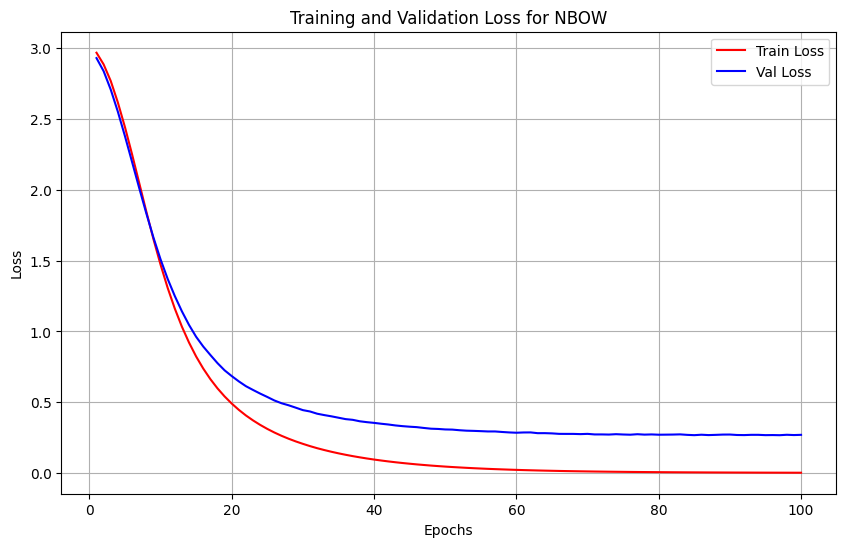

In [252]:
# DO NOT CHANGE THIS CELL - retain the outputs in submission PDF for credits  
plot_loss(train_loss_over_time_nbow, val_loss_over_time_nbow, 'NBOW')

### 3.6. Model Evaluation [2 points - Programming]
The final points for this will be awarded as per Gradescope's test split, which is different from the local versions. The cell below is just for a sanity check. Your metrics here may not exactly match with the ones on Gradescope, but if your model is fairly generalized, it should not be far off.
- 0 points for accuracy <= 84%
- 1 point for accuracy > 84% but <= 88%
- 2 points for accuracy > 88%

In [253]:
# load best model from checkpoint
# DO NOT CHANGE THIS CELL
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
load_checkpoint(nbow_model, 'nbow', map_location=device)

# evaluate model 
true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.59it/s]

Final Validation Accuracy: 0.9315649867374005
Final Validation F1-Score: 0.9297063256768288


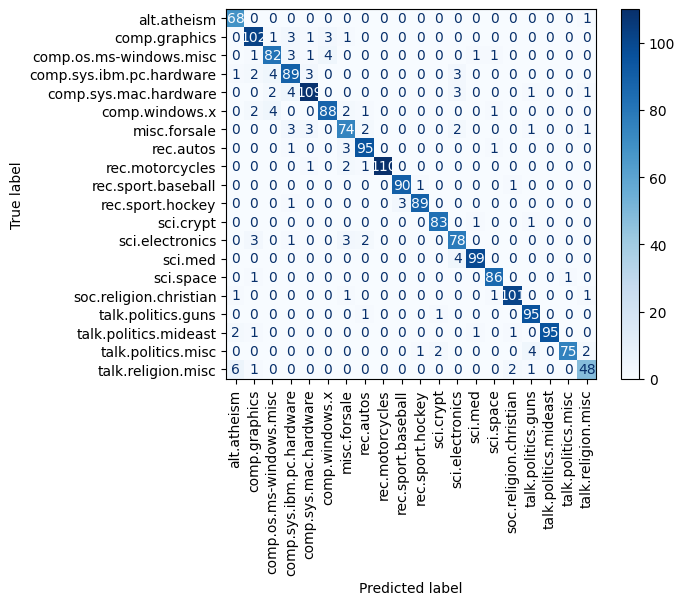

In [254]:
# DO NOT CHANGE THIS CELL 
plot_confusion_matrix(true, pred, classes=id2label.values())

## 4. Simple Deep Averaging Networks (DAN) [5 points - Programming + 3 points - Non-programming]

Now, let's look at how to improve performance of the NBOW model. One such way without drastically changing the model complexity is DAN.

The core idea of a DAN is to simplify the process of understanding text by averaging the embeddings of words in a sentence or document. This creates a single vector representation that captures the overall meaning of the text.

In implementation, a DAN typically involves the following steps:

1. Convert each token into an embedding.
2. Average these embeddings to create a single vector that represents the entire document.
3. Pass this averaged vector through one hidden fully connected neural network layer.
4. Use ReLU activation
5. Use the output of these layers for tasks like classification.

This approach is simpler and often faster than more complex architectures like LSTMs or Transformers, while still providing robust performance for many tasks. However, it might not capture nuances in language as effectively as these more complex models.

*NOTE*: Use the same approach to handle pad_tokens as you used in NBOW.

### 4.1. Model Definition [3 points - Programming]

In the following cell, define the architecture of a DAN in the same way as you implemented NBOW-RAND in Section 2 with. Use the following image as a reference along with Section 3 and Figure 1 (right) of [this paper](https://www.aclweb.org/anthology/P15-1162.pdf).

Refer to the following equation on how to define DAN -


$$ h_{avg} = \frac{1}{n} \sum_t emb(x_t) $$

$$ h_2 = (w_1h_{avg}) $$

$$ h'_{2} = max(0, h_2) $$

The probability of a data instance belonging to class $y_i$ is given by:

$$ p(y|x) = softmax(w_2^T h'_{2} + b) $$

where $w \in R^d$ is a parameter vector.

*Hint*: Make sure to handle the case where the input contains pad tokens. We don't want to consider them in our average.


In [378]:
# export
class DAN(nn.Module):
    # Instantiate layers for your model-
    #
    # Your model architecture will be a feed-forward neural network.
    #
    # You'll need 5 nn.Modules:
    # 1. An embeddings layer (see nn.Embedding)
    # 2. A linear layer (see nn.Linear)
    # 3. A ReLU activation (see nn.ReLU)
    # 4. A linear layer (see nn.Linear)
    #
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes=20):
        # voab_size is the size of the vocabulary
        # use bias in your hidden layer
        # embedding_dim is the dimension of the word embeddings
        # hidden_dim is the dimension of the hidden layer outputs, i.e., the 2nd module as per the definition above
        super().__init__()
        ## YOUR CODE STARTS HERE ##
    
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes

        self.embedding = nn.Embedding(vocab_size, embedding_dim) # 2 x 5
        self.hidden = nn.Linear(embedding_dim, hidden_dim) # 1 x 3
        self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_dim, num_classes)

        ## YOUR CODE ENDS HERE ##

    # Complete the forward pass of the model.
    #
    # Use the output of the embedding layer to create
    # the average vector, which will be input into the
    # linear layer.
    #
    # args:
    # x - 2D LongTensor of shape (BATCH_SIZE, max len of all tokenized_word_tensor))
    #     This is the same output that comes out of the collate_fn function you completed
    def forward(self, x):
        ## YOUR CODE STARTS HERE ##
        hidden = self.get_hidden(x) 
        relu_out = self.relu(hidden) 
        return self.linear(relu_out)  

        ## YOUR CODE ENDS HERE ##
    
    def get_embeddings(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        
        return self.embedding(x)

        ### YOUR CODE ENDS HERE ###
    
    def set_embedding_weight(self, weight):
        '''
        This function sets the embedding weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (vocab_size, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###

        self.embedding.weight = nn.Parameter(weight, requires_grad=False)
        
        ### YOUR CODE ENDS HERE ###
    
    def get_hidden(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###

        embeddings = self.get_embeddings(x)

        mask = (x!= PADDING_VALUE)

        # Count the number of non-padding tokens in each sequence for averaging later
        num_non_pads = mask.sum(dim=1).unsqueeze(-1)

        # Apply the mask to the embeddings
        embeddings = embeddings * mask.unsqueeze(-1) 

        avg_embeddings = embeddings.sum(dim=1)/num_non_pads # gives batch_size x 1
    
        return self.hidden(avg_embeddings)

        ### YOUR CODE ENDS HERE ###
    
    def set_hidden_weight(self, weight, bias):
        '''
        This function sets the embedding weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (embedding_dim, hidden_dim)
            bias: torch.tensor of shape (1, hidden_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        
        self.hidden.weight = nn.Parameter(weight, requires_grad=False)
        self.hidden.bias = nn.Parameter(bias.view(-1), requires_grad=False)

        ### YOUR CODE ENDS HERE ###


In [379]:
# local test for sanity:
# DO NOT CHANGE THIS CELL
def dan_test_local_embeddings():
    embedding_dim = 3
    vocab_size = 5
    model = DAN(embedding_dim=embedding_dim, vocab_size=vocab_size, hidden_dim=10)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    embeddings = model.get_embeddings(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_embeddings = torch.tensor([[[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.2400, 0.2600, 0.2800],
                                        [0.0600, 0.0800, 0.1000]],

                                        [[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.0000, 0.0200, 0.0400],
                                        [0.0000, 0.0200, 0.0400]]])
    if torch.allclose(embeddings, correct_embeddings, rtol=0.001):
        print("Passed local embedding test")
    else:
        print(f"Embedding Test failed, expected value was\n{correct_embeddings}\nbut you got:\n{embeddings}")
    
def dan_test_local_hidden_layer():
    vocab_size = 5
    embedding_dim = 3
    hidden_dim = 3
    
    model = DAN(vocab_size, embedding_dim, hidden_dim)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    model.set_hidden_weight(torch.arange(9).reshape(embedding_dim, hidden_dim) / 50, torch.arange(3).reshape(1, hidden_dim) / 50)
    
    output = model.get_hidden(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_output = torch.tensor([[0.0099, 0.0573, 0.1046],
                                    [0.0092, 0.0544, 0.0996]])
    
    if torch.allclose(output, correct_output, atol=0.001):
        print("Passed local hidden layer test")
    else:
        print(f"Embedding Test failed, expected value was\n{correct_output}\nbut you got:\n{output}")

dan_test_local_embeddings()
dan_test_local_hidden_layer()

Passed local embedding test
Passed local hidden layer test


### 4.2. DAN Training [3 points - Non-programming]

In this section (and all later sections), you will leverage the same functions defined in Section 3 to train your DAN. To do this, simply initialize your DAN Model and pass that object to the training and evaluation loop to train your model.

Assign and tune the below hyperparameters to optimize your model

In [380]:
# export
def get_dan_model(vocab_size, embedding_dim, hidden_dim):
    """
    This function returns an instance of the DAN model. Initialize the DAN model here and return it. Note that the hidden_dim will be the dimension of the hidden layer in DAN.
    """
    ## YOUR CODE STARTS HERE ##

    model = DAN(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim)

    ## YOUR CODE ENDS HERE ##
    return model

In [424]:
#export
# Assign hyperparameters and training parameters
# Experiment with different values for these hyperparaters to optimize your model's performance
def get_hyperparams_dan():
  ### your hyper parameters
    learning_rate = 0.001
    epochs = 150
    hidden_layer_dimensions = 100
    embedding_dim = 100
    ### 
    return learning_rate, epochs, hidden_layer_dimensions, embedding_dim


In [425]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, hidden_layer_dimensions, embedding_dim = get_hyperparams_dan()
dan_model = get_dan_model(len(train_vocab.keys()), embedding_dim, hidden_layer_dimensions).to(device)
criterion = get_criterion()
optimizer = get_optimizer(dan_model, learning_rate)
train_loss_over_time_dan = []
val_loss_over_time_dan = []
for epoch in range(epochs):
    train_loss = train_loop(dan_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(dan_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    train_loss_over_time_dan.append(train_loss)
    val_loss_over_time_dan.append(val_loss)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")

save_checkpoint(dan_model, 'dan')

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.88it/s]


Epoch 1 -- Train_Loss: 2.9285195661803423 -- Val_Loss: 2.795743735631307 -- Val_Accuracy: 0.15437665782493368 -- Val_F1: 0.09006646845067667


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.46it/s]


Epoch 2 -- Train_Loss: 2.601733678478306 -- Val_Loss: 2.4042089303334553 -- Val_Accuracy: 0.26790450928381965 -- Val_F1: 0.22054483041586873


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.85it/s]


Epoch 3 -- Train_Loss: 2.1862466537346275 -- Val_Loss: 2.0079812526702883 -- Val_Accuracy: 0.4042440318302387 -- Val_F1: 0.37809391237960055


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.38it/s]


Epoch 4 -- Train_Loss: 1.7605587435980974 -- Val_Loss: 1.6419713973999024 -- Val_Accuracy: 0.5188328912466843 -- Val_F1: 0.4881942811585409


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.26it/s]


Epoch 5 -- Train_Loss: 1.3595039490926064 -- Val_Loss: 1.3345019737879436 -- Val_Accuracy: 0.6137931034482759 -- Val_F1: 0.5977346934996306


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.49it/s]


Epoch 6 -- Train_Loss: 1.0342122467897705 -- Val_Loss: 1.0975366751352946 -- Val_Accuracy: 0.6827586206896552 -- Val_F1: 0.6707788553311546


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.28it/s]


Epoch 7 -- Train_Loss: 0.7906731316598795 -- Val_Loss: 0.9300889412562052 -- Val_Accuracy: 0.7389920424403184 -- Val_F1: 0.7347513265615677


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.98it/s]


Epoch 8 -- Train_Loss: 0.6076015726489535 -- Val_Loss: 0.8107324918111165 -- Val_Accuracy: 0.7697612732095491 -- Val_F1: 0.7695475922542475


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.27it/s]


Epoch 9 -- Train_Loss: 0.4731833765567359 -- Val_Loss: 0.7195597211519877 -- Val_Accuracy: 0.7946949602122015 -- Val_F1: 0.7931605832957207


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 59.49it/s]


Epoch 10 -- Train_Loss: 0.36951714299492916 -- Val_Loss: 0.6547013719876608 -- Val_Accuracy: 0.8143236074270557 -- Val_F1: 0.8120645925806768


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.70it/s]


Epoch 11 -- Train_Loss: 0.29096408365136484 -- Val_Loss: 0.6033173243204752 -- Val_Accuracy: 0.8238726790450929 -- Val_F1: 0.8228538822376507


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.69it/s]


Epoch 12 -- Train_Loss: 0.2292192484867775 -- Val_Loss: 0.5794363180796306 -- Val_Accuracy: 0.830238726790451 -- Val_F1: 0.8295769773340581


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 59.38it/s]


Epoch 13 -- Train_Loss: 0.18303573560916772 -- Val_Loss: 0.5496700664361318 -- Val_Accuracy: 0.8339522546419098 -- Val_F1: 0.8338681078410852


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.26it/s]


Epoch 14 -- Train_Loss: 0.14638714934304609 -- Val_Loss: 0.5296935816605886 -- Val_Accuracy: 0.8408488063660478 -- Val_F1: 0.8382510210394791


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.32it/s]


Epoch 15 -- Train_Loss: 0.11730057241047843 -- Val_Loss: 0.5117921670277913 -- Val_Accuracy: 0.8488063660477454 -- Val_F1: 0.8453928707131972


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.65it/s]


Epoch 16 -- Train_Loss: 0.09427482786320024 -- Val_Loss: 0.5045579155286153 -- Val_Accuracy: 0.8541114058355438 -- Val_F1: 0.85197938916727


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.82it/s]


Epoch 17 -- Train_Loss: 0.07633303917186746 -- Val_Loss: 0.4913201252619425 -- Val_Accuracy: 0.8567639257294429 -- Val_F1: 0.8548408982735138


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.52it/s]


Epoch 18 -- Train_Loss: 0.062291776666701854 -- Val_Loss: 0.49225515127182007 -- Val_Accuracy: 0.859946949602122 -- Val_F1: 0.8586989598495233


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.03it/s]


Epoch 19 -- Train_Loss: 0.05127178287228285 -- Val_Loss: 0.489843362569809 -- Val_Accuracy: 0.863129973474801 -- Val_F1: 0.8620157560654205


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.54it/s]


Epoch 20 -- Train_Loss: 0.04192152624097416 -- Val_Loss: 0.492550524075826 -- Val_Accuracy: 0.8610079575596817 -- Val_F1: 0.8601750798292731


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.53it/s]


Epoch 21 -- Train_Loss: 0.034677147952113616 -- Val_Loss: 0.4821489373842875 -- Val_Accuracy: 0.86684350132626 -- Val_F1: 0.8652165047790603


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.89it/s]


Epoch 22 -- Train_Loss: 0.02874473735721687 -- Val_Loss: 0.48161009351412454 -- Val_Accuracy: 0.8673740053050398 -- Val_F1: 0.8653717413055894


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.88it/s]


Epoch 23 -- Train_Loss: 0.023954872681238387 -- Val_Loss: 0.4852979779243469 -- Val_Accuracy: 0.8663129973474801 -- Val_F1: 0.8647704450819733


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.50it/s]


Epoch 24 -- Train_Loss: 0.020419498274134376 -- Val_Loss: 0.4815889676411947 -- Val_Accuracy: 0.8679045092838197 -- Val_F1: 0.8662275267080046


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 59.93it/s]


Epoch 25 -- Train_Loss: 0.017444496232447988 -- Val_Loss: 0.4867189387480418 -- Val_Accuracy: 0.870026525198939 -- Val_F1: 0.8682149336565119


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.93it/s]


Epoch 26 -- Train_Loss: 0.014944073649407443 -- Val_Loss: 0.4856267551581065 -- Val_Accuracy: 0.8694960212201591 -- Val_F1: 0.8676471319876867


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.02it/s]


Epoch 27 -- Train_Loss: 0.012884400224597272 -- Val_Loss: 0.4950670500596364 -- Val_Accuracy: 0.8694960212201591 -- Val_F1: 0.868168284286331


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 58.48it/s]


Epoch 28 -- Train_Loss: 0.011293982439753363 -- Val_Loss: 0.48710397879282635 -- Val_Accuracy: 0.8710875331564987 -- Val_F1: 0.8692432089224121


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.11it/s]


Epoch 29 -- Train_Loss: 0.009967804156338512 -- Val_Loss: 0.4960143188635508 -- Val_Accuracy: 0.8689655172413793 -- Val_F1: 0.8676926931060441


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.40it/s]


Epoch 30 -- Train_Loss: 0.00883575076616164 -- Val_Loss: 0.4923718472321828 -- Val_Accuracy: 0.8705570291777188 -- Val_F1: 0.8697435393844988


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.36it/s]


Epoch 31 -- Train_Loss: 0.00781116849087747 -- Val_Loss: 0.4934417188167572 -- Val_Accuracy: 0.8679045092838197 -- Val_F1: 0.8663282450778453


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.33it/s]


Epoch 32 -- Train_Loss: 0.0069708720982169445 -- Val_Loss: 0.502370743950208 -- Val_Accuracy: 0.8726790450928382 -- Val_F1: 0.8710880415153012


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.83it/s]


Epoch 33 -- Train_Loss: 0.0062103360532230496 -- Val_Loss: 0.5037343819936116 -- Val_Accuracy: 0.8694960212201591 -- Val_F1: 0.8679078197669108


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.57it/s]


Epoch 34 -- Train_Loss: 0.005634953179080986 -- Val_Loss: 0.5028366724650065 -- Val_Accuracy: 0.8748010610079575 -- Val_F1: 0.8730196693264858


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.44it/s]


Epoch 35 -- Train_Loss: 0.0050805237566483984 -- Val_Loss: 0.513114070892334 -- Val_Accuracy: 0.8679045092838197 -- Val_F1: 0.8666973241084419


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.41it/s]


Epoch 36 -- Train_Loss: 0.004728037375617393 -- Val_Loss: 0.5023027658462524 -- Val_Accuracy: 0.8742705570291777 -- Val_F1: 0.872859392442504


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 59.37it/s]


Epoch 37 -- Train_Loss: 0.004540645016231022 -- Val_Loss: 0.5123228967189789 -- Val_Accuracy: 0.8732095490716181 -- Val_F1: 0.8723626369928541


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 53.62it/s]


Epoch 38 -- Train_Loss: 0.003836810348113462 -- Val_Loss: 0.5094422896703085 -- Val_Accuracy: 0.8726790450928382 -- Val_F1: 0.871146062161643


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.71it/s]


Epoch 39 -- Train_Loss: 0.0036299188228687113 -- Val_Loss: 0.5213734149932862 -- Val_Accuracy: 0.8716180371352785 -- Val_F1: 0.8700479990608194


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.48it/s]


Epoch 40 -- Train_Loss: 0.00340822955960471 -- Val_Loss: 0.5261187116305034 -- Val_Accuracy: 0.8726790450928382 -- Val_F1: 0.8713943945105506


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.76it/s]


Epoch 41 -- Train_Loss: 0.003079316978366509 -- Val_Loss: 0.5273926883935929 -- Val_Accuracy: 0.8710875331564987 -- Val_F1: 0.8696648162567809


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.57it/s]


Epoch 42 -- Train_Loss: 0.0030028532057905853 -- Val_Loss: 0.5316457410653432 -- Val_Accuracy: 0.8721485411140584 -- Val_F1: 0.8707736028237152


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.80it/s]


Epoch 43 -- Train_Loss: 0.0028160315192446617 -- Val_Loss: 0.5236893614133199 -- Val_Accuracy: 0.8726790450928382 -- Val_F1: 0.871345162520584


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.40it/s]


Epoch 44 -- Train_Loss: 0.0024872075409186466 -- Val_Loss: 0.5282070279121399 -- Val_Accuracy: 0.8737400530503979 -- Val_F1: 0.8722365744204643


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.26it/s]


Epoch 45 -- Train_Loss: 0.002337571577824084 -- Val_Loss: 0.5277429441610972 -- Val_Accuracy: 0.8763925729442971 -- Val_F1: 0.8746056723597663


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.88it/s]


Epoch 46 -- Train_Loss: 0.0023817564015497722 -- Val_Loss: 0.5364071369171143 -- Val_Accuracy: 0.8774535809018568 -- Val_F1: 0.8754423228889398


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.45it/s]


Epoch 47 -- Train_Loss: 0.001994002166981572 -- Val_Loss: 0.5356027921040852 -- Val_Accuracy: 0.8753315649867374 -- Val_F1: 0.8737275567306184


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.63it/s]


Epoch 48 -- Train_Loss: 0.0021677917457517174 -- Val_Loss: 0.5407245635986329 -- Val_Accuracy: 0.8753315649867374 -- Val_F1: 0.8736092367952815


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.46it/s]


Epoch 49 -- Train_Loss: 0.0020838104098664313 -- Val_Loss: 0.5390313466389974 -- Val_Accuracy: 0.8742705570291777 -- Val_F1: 0.8727388996725134


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.49it/s]


Epoch 50 -- Train_Loss: 0.002092767123555196 -- Val_Loss: 0.55303995013237 -- Val_Accuracy: 0.8726790450928382 -- Val_F1: 0.8712452806274327


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.91it/s]


Epoch 51 -- Train_Loss: 0.0016523013389629895 -- Val_Loss: 0.5449607531229655 -- Val_Accuracy: 0.8742705570291777 -- Val_F1: 0.8726152291975666


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.25it/s]


Epoch 52 -- Train_Loss: 0.0016481698849790934 -- Val_Loss: 0.5912555158138275 -- Val_Accuracy: 0.8657824933687003 -- Val_F1: 0.864680524727849


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.33it/s]


Epoch 53 -- Train_Loss: 0.0015807404691921705 -- Val_Loss: 0.5787252883116404 -- Val_Accuracy: 0.8679045092838197 -- Val_F1: 0.8665820633165373


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.36it/s]


Epoch 54 -- Train_Loss: 0.0014783176092797953 -- Val_Loss: 0.5731847008069356 -- Val_Accuracy: 0.8673740053050398 -- Val_F1: 0.8665411541693336


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.37it/s]


Epoch 55 -- Train_Loss: 0.0014295274908733317 -- Val_Loss: 0.5572208742300669 -- Val_Accuracy: 0.8758620689655172 -- Val_F1: 0.8742442869523679


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.40it/s]


Epoch 56 -- Train_Loss: 0.001250370841431905 -- Val_Loss: 0.551499613126119 -- Val_Accuracy: 0.8758620689655172 -- Val_F1: 0.8735971167168304


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.47it/s]


Epoch 57 -- Train_Loss: 0.0013656003200409586 -- Val_Loss: 0.5563202500343323 -- Val_Accuracy: 0.8721485411140584 -- Val_F1: 0.8709589881794342


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.27it/s]


Epoch 58 -- Train_Loss: 0.001330099197576154 -- Val_Loss: 0.5682006676991781 -- Val_Accuracy: 0.8694960212201591 -- Val_F1: 0.8682743898048384


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.66it/s]


Epoch 59 -- Train_Loss: 0.0011854533713322795 -- Val_Loss: 0.5674808780352275 -- Val_Accuracy: 0.8785145888594165 -- Val_F1: 0.8766382269458892


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.91it/s]


Epoch 60 -- Train_Loss: 0.001089961219419157 -- Val_Loss: 0.5929373741149903 -- Val_Accuracy: 0.8721485411140584 -- Val_F1: 0.8715291820053466


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.62it/s]


Epoch 61 -- Train_Loss: 0.0012559334678926616 -- Val_Loss: 0.5771421968936921 -- Val_Accuracy: 0.8763925729442971 -- Val_F1: 0.8749314868847604


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.14it/s]


Epoch 62 -- Train_Loss: 0.0016278359145902776 -- Val_Loss: 0.5633334914843241 -- Val_Accuracy: 0.8742705570291777 -- Val_F1: 0.8733371223286929


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.23it/s]


Epoch 63 -- Train_Loss: 0.0009176574588972302 -- Val_Loss: 0.5894353926181793 -- Val_Accuracy: 0.8753315649867374 -- Val_F1: 0.8736043221640057


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.76it/s]


Epoch 64 -- Train_Loss: 0.0009280209759076647 -- Val_Loss: 0.5678742925326029 -- Val_Accuracy: 0.8763925729442971 -- Val_F1: 0.8749628169603731


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.92it/s]


Epoch 65 -- Train_Loss: 0.0013395544854081553 -- Val_Loss: 0.5913139343261719 -- Val_Accuracy: 0.8748010610079575 -- Val_F1: 0.8731383975637309


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.30it/s]


Epoch 66 -- Train_Loss: 0.0010511791318757618 -- Val_Loss: 0.5989778856436412 -- Val_Accuracy: 0.8705570291777188 -- Val_F1: 0.8695943386150669


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.55it/s]


Epoch 67 -- Train_Loss: 0.0011981067810527253 -- Val_Loss: 0.6161176443099976 -- Val_Accuracy: 0.8679045092838197 -- Val_F1: 0.8667012687042334


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.47it/s]


Epoch 68 -- Train_Loss: 0.0010936529686629093 -- Val_Loss: 0.6505287150541942 -- Val_Accuracy: 0.8679045092838197 -- Val_F1: 0.8673966079174784


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.67it/s]


Epoch 69 -- Train_Loss: 0.0008088194740979569 -- Val_Loss: 0.5941341519355774 -- Val_Accuracy: 0.8742705570291777 -- Val_F1: 0.871958214859745


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.15it/s]


Epoch 70 -- Train_Loss: 0.0011916352788398784 -- Val_Loss: 0.6019024153550466 -- Val_Accuracy: 0.8732095490716181 -- Val_F1: 0.8718896609969697


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.97it/s]


Epoch 71 -- Train_Loss: 0.0006673408280545056 -- Val_Loss: 0.6137503484884897 -- Val_Accuracy: 0.8641909814323607 -- Val_F1: 0.8623464629233325


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.34it/s]


Epoch 72 -- Train_Loss: 0.000592718533880543 -- Val_Loss: 0.590379512310028 -- Val_Accuracy: 0.8748010610079575 -- Val_F1: 0.8728173412848796


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.33it/s]


Epoch 73 -- Train_Loss: 0.0008285197060504904 -- Val_Loss: 0.580060675740242 -- Val_Accuracy: 0.8790450928381963 -- Val_F1: 0.8769092041542935


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.32it/s]


Epoch 74 -- Train_Loss: 0.0009182895624011724 -- Val_Loss: 0.6409108837445577 -- Val_Accuracy: 0.870026525198939 -- Val_F1: 0.8694703615573731


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.69it/s]


Epoch 75 -- Train_Loss: 0.0009154651996110352 -- Val_Loss: 0.6816182136535645 -- Val_Accuracy: 0.8684350132625994 -- Val_F1: 0.8680946642254517


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.22it/s]


Epoch 76 -- Train_Loss: 0.000528565614007737 -- Val_Loss: 0.6062604069709778 -- Val_Accuracy: 0.8790450928381963 -- Val_F1: 0.8769567604213468


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.06it/s]


Epoch 77 -- Train_Loss: 0.0009409119449042857 -- Val_Loss: 0.6015116026004156 -- Val_Accuracy: 0.8763925729442971 -- Val_F1: 0.8746801863191458


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.37it/s]


Epoch 78 -- Train_Loss: 0.0018241097922466491 -- Val_Loss: 0.6115044037501017 -- Val_Accuracy: 0.8710875331564987 -- Val_F1: 0.8697098265794889


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.06it/s]


Epoch 79 -- Train_Loss: 0.0010404458200540276 -- Val_Loss: 0.5936700205008189 -- Val_Accuracy: 0.8785145888594165 -- Val_F1: 0.8773622876586549


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.77it/s]


Epoch 80 -- Train_Loss: 0.0010781362560904246 -- Val_Loss: 0.6134978016217549 -- Val_Accuracy: 0.8779840848806366 -- Val_F1: 0.8764021444367917


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.00it/s]


Epoch 81 -- Train_Loss: 0.000519852542326543 -- Val_Loss: 0.6928190430005391 -- Val_Accuracy: 0.8663129973474801 -- Val_F1: 0.8649273543995228


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.39it/s]


Epoch 82 -- Train_Loss: 0.0006791566190520948 -- Val_Loss: 0.6202656964461009 -- Val_Accuracy: 0.8790450928381963 -- Val_F1: 0.8773716857064991


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.90it/s]


Epoch 83 -- Train_Loss: 0.0008087185936239036 -- Val_Loss: 0.6270095785458882 -- Val_Accuracy: 0.8785145888594165 -- Val_F1: 0.8765708708637415


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.05it/s]


Epoch 84 -- Train_Loss: 0.0008445057910802909 -- Val_Loss: 0.6097571134567261 -- Val_Accuracy: 0.8758620689655172 -- Val_F1: 0.8742167108566703


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.87it/s]


Epoch 85 -- Train_Loss: 0.0004068737429930726 -- Val_Loss: 0.6223377724488576 -- Val_Accuracy: 0.8737400530503979 -- Val_F1: 0.8716798634781722


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 59.76it/s]


Epoch 86 -- Train_Loss: 0.0005928583522583753 -- Val_Loss: 0.6188130021095276 -- Val_Accuracy: 0.8779840848806366 -- Val_F1: 0.8763587935702608


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.03it/s]


Epoch 87 -- Train_Loss: 0.0003959657909544441 -- Val_Loss: 0.6660635590553283 -- Val_Accuracy: 0.8684350132625994 -- Val_F1: 0.867553183499643


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.48it/s]


Epoch 88 -- Train_Loss: 0.00030795371143756063 -- Val_Loss: 0.6165759245554606 -- Val_Accuracy: 0.8790450928381963 -- Val_F1: 0.8772589148413642


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.94it/s]


Epoch 89 -- Train_Loss: 0.00025151159157542417 -- Val_Loss: 0.6646291156609853 -- Val_Accuracy: 0.8673740053050398 -- Val_F1: 0.8672066078043624


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.62it/s]


Epoch 90 -- Train_Loss: 0.0008556722176902024 -- Val_Loss: 0.6395090460777283 -- Val_Accuracy: 0.8742705570291777 -- Val_F1: 0.8725766113134676


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.64it/s]


Epoch 91 -- Train_Loss: 0.0004069793814192901 -- Val_Loss: 0.6354248662789662 -- Val_Accuracy: 0.8742705570291777 -- Val_F1: 0.8732383379931387


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.09it/s]


Epoch 92 -- Train_Loss: 0.0011848287117804137 -- Val_Loss: 0.6180825054645538 -- Val_Accuracy: 0.8785145888594165 -- Val_F1: 0.8771754276111363


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.54it/s]


Epoch 93 -- Train_Loss: 0.00024105141189573846 -- Val_Loss: 0.6174678901831309 -- Val_Accuracy: 0.8811671087533156 -- Val_F1: 0.8791485018720342


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 59.96it/s]


Epoch 94 -- Train_Loss: 0.0002909263076632623 -- Val_Loss: 0.6598369439442953 -- Val_Accuracy: 0.8753315649867374 -- Val_F1: 0.8736143746522187


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.25it/s]


Epoch 95 -- Train_Loss: 0.0002629552892065445 -- Val_Loss: 0.6476258913675944 -- Val_Accuracy: 0.8806366047745358 -- Val_F1: 0.8791516306962344


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.93it/s]


Epoch 96 -- Train_Loss: 0.0006793874671360353 -- Val_Loss: 0.6612088263034821 -- Val_Accuracy: 0.8774535809018568 -- Val_F1: 0.8753082094594596


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.72it/s]


Epoch 97 -- Train_Loss: 0.0007833011723975641 -- Val_Loss: 0.6370173712571462 -- Val_Accuracy: 0.8806366047745358 -- Val_F1: 0.8785727005314119


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.25it/s]


Epoch 98 -- Train_Loss: 0.0012473096898155114 -- Val_Loss: 0.7022182325522105 -- Val_Accuracy: 0.8774535809018568 -- Val_F1: 0.8761607911137889


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.93it/s]


Epoch 99 -- Train_Loss: 0.0012656751768175174 -- Val_Loss: 0.6549753308296203 -- Val_Accuracy: 0.8737400530503979 -- Val_F1: 0.872165669190881


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.62it/s]


Epoch 100 -- Train_Loss: 0.0003442085790392396 -- Val_Loss: 0.6610591689745585 -- Val_Accuracy: 0.8758620689655172 -- Val_F1: 0.874199546609572


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.05it/s]


Epoch 101 -- Train_Loss: 0.0005089010761305147 -- Val_Loss: 0.6476793428262074 -- Val_Accuracy: 0.8806366047745358 -- Val_F1: 0.8785284783524228


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.59it/s]


Epoch 102 -- Train_Loss: 0.0002427553891582154 -- Val_Loss: 0.7193219085534414 -- Val_Accuracy: 0.8705570291777188 -- Val_F1: 0.8693449229574967


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.82it/s]


Epoch 103 -- Train_Loss: 0.0007718874160102933 -- Val_Loss: 0.6679475128650665 -- Val_Accuracy: 0.8758620689655172 -- Val_F1: 0.8745488857052693


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.23it/s]


Epoch 104 -- Train_Loss: 0.0004464261015003766 -- Val_Loss: 0.6660209059715271 -- Val_Accuracy: 0.8758620689655172 -- Val_F1: 0.8736982385363309


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.21it/s]


Epoch 105 -- Train_Loss: 0.000678451104742974 -- Val_Loss: 0.6660890420277913 -- Val_Accuracy: 0.8785145888594165 -- Val_F1: 0.8767050248543791


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 59.13it/s]


Epoch 106 -- Train_Loss: 0.0003151219765394502 -- Val_Loss: 0.6989407042662302 -- Val_Accuracy: 0.8758620689655172 -- Val_F1: 0.8736443943467467


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.03it/s]


Epoch 107 -- Train_Loss: 0.0004758051022382476 -- Val_Loss: 0.6863407055536906 -- Val_Accuracy: 0.8748010610079575 -- Val_F1: 0.8735893090215852


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.84it/s]


Epoch 108 -- Train_Loss: 0.0001344632216032705 -- Val_Loss: 0.6467418034871419 -- Val_Accuracy: 0.880106100795756 -- Val_F1: 0.8788217205010987


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.54it/s]


Epoch 109 -- Train_Loss: 0.0001144552514048528 -- Val_Loss: 0.646902734041214 -- Val_Accuracy: 0.8843501326259947 -- Val_F1: 0.882357186108153


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 63.00it/s]


Epoch 110 -- Train_Loss: 5.0581988073074974e-05 -- Val_Loss: 0.6531563202540079 -- Val_Accuracy: 0.880106100795756 -- Val_F1: 0.8783727626983204


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.94it/s]


Epoch 111 -- Train_Loss: 5.760692006256481e-05 -- Val_Loss: 0.6532662034034729 -- Val_Accuracy: 0.8838196286472149 -- Val_F1: 0.8816108551629238


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.33it/s]


Epoch 112 -- Train_Loss: 5.968189887395148e-05 -- Val_Loss: 0.6611642599105835 -- Val_Accuracy: 0.8785145888594165 -- Val_F1: 0.87686035932691


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.08it/s]


Epoch 113 -- Train_Loss: 0.00010886180233051241 -- Val_Loss: 0.6851973096529643 -- Val_Accuracy: 0.8753315649867374 -- Val_F1: 0.873640909451405


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.60it/s]


Epoch 114 -- Train_Loss: 0.0006623881597418295 -- Val_Loss: 0.7133657038211823 -- Val_Accuracy: 0.8753315649867374 -- Val_F1: 0.873156366561024


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.97it/s]


Epoch 115 -- Train_Loss: 0.0005449702886018436 -- Val_Loss: 0.6605219364166259 -- Val_Accuracy: 0.880106100795756 -- Val_F1: 0.8780248415498321


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.53it/s]


Epoch 116 -- Train_Loss: 0.0005161562950380064 -- Val_Loss: 0.6709108551343282 -- Val_Accuracy: 0.8774535809018568 -- Val_F1: 0.8762619034181197


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.36it/s]


Epoch 117 -- Train_Loss: 0.000414622723915041 -- Val_Loss: 0.7315050025780996 -- Val_Accuracy: 0.8721485411140584 -- Val_F1: 0.8704196330137819


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.52it/s]


Epoch 118 -- Train_Loss: 0.0010308165410066775 -- Val_Loss: 0.6595212578773498 -- Val_Accuracy: 0.8806366047745358 -- Val_F1: 0.8784378240393986


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.31it/s]


Epoch 119 -- Train_Loss: 0.0004032993767041416 -- Val_Loss: 0.716911127169927 -- Val_Accuracy: 0.8705570291777188 -- Val_F1: 0.8689585266742675


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 62.33it/s]


Epoch 120 -- Train_Loss: 0.0003200026086556984 -- Val_Loss: 0.6748210906982421 -- Val_Accuracy: 0.8758620689655172 -- Val_F1: 0.8747358787657948


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.94it/s]


Epoch 121 -- Train_Loss: 0.0010097551704517573 -- Val_Loss: 0.7183297316233317 -- Val_Accuracy: 0.8790450928381963 -- Val_F1: 0.8784091637257143


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.08it/s]


Epoch 122 -- Train_Loss: 0.00054654345516826 -- Val_Loss: 0.6866941630840302 -- Val_Accuracy: 0.870026525198939 -- Val_F1: 0.8688478858226392


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.94it/s]


Epoch 123 -- Train_Loss: 0.00013727696511785448 -- Val_Loss: 0.6754788239796956 -- Val_Accuracy: 0.8795755968169762 -- Val_F1: 0.8771418025368115


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.10it/s]


Epoch 124 -- Train_Loss: 0.00018021706036807253 -- Val_Loss: 0.7644020815690359 -- Val_Accuracy: 0.8684350132625994 -- Val_F1: 0.8683812762699906


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.18it/s]


Epoch 125 -- Train_Loss: 0.0010510120242327242 -- Val_Loss: 0.7496496359507243 -- Val_Accuracy: 0.8732095490716181 -- Val_F1: 0.8725804503224068


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.95it/s]


Epoch 126 -- Train_Loss: 0.001105631964808215 -- Val_Loss: 0.706285148859024 -- Val_Accuracy: 0.8742705570291777 -- Val_F1: 0.8731313042148787


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.48it/s]


Epoch 127 -- Train_Loss: 0.0006140884299492103 -- Val_Loss: 0.7106282015641531 -- Val_Accuracy: 0.8732095490716181 -- Val_F1: 0.8720791194951276


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.94it/s]


Epoch 128 -- Train_Loss: 0.0005581555952646294 -- Val_Loss: 0.7037230889002483 -- Val_Accuracy: 0.8763925729442971 -- Val_F1: 0.8752117982358236


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.59it/s]


Epoch 129 -- Train_Loss: 0.0002491751161730879 -- Val_Loss: 0.7064244985580445 -- Val_Accuracy: 0.8795755968169762 -- Val_F1: 0.8777001417043475


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 57.41it/s]


Epoch 130 -- Train_Loss: 0.00013149645970169315 -- Val_Loss: 0.703088887532552 -- Val_Accuracy: 0.8758620689655172 -- Val_F1: 0.8745174827554436


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 59.44it/s]


Epoch 131 -- Train_Loss: 0.00010637399938047057 -- Val_Loss: 0.7070715089639028 -- Val_Accuracy: 0.8790450928381963 -- Val_F1: 0.8770682808918714


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.16it/s]


Epoch 132 -- Train_Loss: 4.741712369665901e-05 -- Val_Loss: 0.6799573580423991 -- Val_Accuracy: 0.8806366047745358 -- Val_F1: 0.8790845267492221


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.58it/s]


Epoch 133 -- Train_Loss: 2.0140167929778312e-05 -- Val_Loss: 0.6818166494369506 -- Val_Accuracy: 0.8790450928381963 -- Val_F1: 0.8773163581740752


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.59it/s]


Epoch 134 -- Train_Loss: 2.0355437388805175e-05 -- Val_Loss: 0.690319033463796 -- Val_Accuracy: 0.8790450928381963 -- Val_F1: 0.8773163581740752


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 59.40it/s]


Epoch 135 -- Train_Loss: 1.9416982915140964e-05 -- Val_Loss: 0.6800979435443878 -- Val_Accuracy: 0.880106100795756 -- Val_F1: 0.8784776903612105


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 58.99it/s]


Epoch 136 -- Train_Loss: 1.829697176016437e-05 -- Val_Loss: 0.6888022740681966 -- Val_Accuracy: 0.880106100795756 -- Val_F1: 0.8782848868507596


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.39it/s]


Epoch 137 -- Train_Loss: 1.8055861298338547e-05 -- Val_Loss: 0.6884013473987579 -- Val_Accuracy: 0.880106100795756 -- Val_F1: 0.8784855501613599


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.16it/s]


Epoch 138 -- Train_Loss: 1.8455009187888764e-05 -- Val_Loss: 0.6846134920914968 -- Val_Accuracy: 0.8795755968169762 -- Val_F1: 0.8778223823362155


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.85it/s]


Epoch 139 -- Train_Loss: 2.1212468341526784e-05 -- Val_Loss: 0.6871836960315705 -- Val_Accuracy: 0.8795755968169762 -- Val_F1: 0.8778408947256947


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.78it/s]


Epoch 140 -- Train_Loss: 1.7023250229535964e-05 -- Val_Loss: 0.7016379356384277 -- Val_Accuracy: 0.8806366047745358 -- Val_F1: 0.8789699418444753


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.67it/s]


Epoch 141 -- Train_Loss: 1.818882793617438e-05 -- Val_Loss: 0.7037080983320873 -- Val_Accuracy: 0.8785145888594165 -- Val_F1: 0.8766051309806249


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.75it/s]


Epoch 142 -- Train_Loss: 1.84191087806015e-05 -- Val_Loss: 0.6881053785483042 -- Val_Accuracy: 0.880106100795756 -- Val_F1: 0.8782657668661618


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.91it/s]


Epoch 143 -- Train_Loss: 1.6214415227758285e-05 -- Val_Loss: 0.7022713502248128 -- Val_Accuracy: 0.8790450928381963 -- Val_F1: 0.8771884653067504


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.47it/s]


Epoch 144 -- Train_Loss: 1.8385002740846393e-05 -- Val_Loss: 0.6928631802399953 -- Val_Accuracy: 0.8822281167108753 -- Val_F1: 0.8807083352242957


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.66it/s]


Epoch 145 -- Train_Loss: 3.394500746538651e-05 -- Val_Loss: 0.7321713586648305 -- Val_Accuracy: 0.8748010610079575 -- Val_F1: 0.8738469811176085


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.23it/s]


Epoch 146 -- Train_Loss: 0.00022082445383279326 -- Val_Loss: 0.8258322268724442 -- Val_Accuracy: 0.870026525198939 -- Val_F1: 0.8703995300095034


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.74it/s]


Epoch 147 -- Train_Loss: 0.001940917900860845 -- Val_Loss: 0.7226857165495555 -- Val_Accuracy: 0.883289124668435 -- Val_F1: 0.8827739205065013


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.15it/s]


Epoch 148 -- Train_Loss: 0.0010917534766114408 -- Val_Loss: 0.7608434875806173 -- Val_Accuracy: 0.8811671087533156 -- Val_F1: 0.8794522706407228


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.63it/s]


Epoch 149 -- Train_Loss: 0.00020895031268807187 -- Val_Loss: 0.7471232056617737 -- Val_Accuracy: 0.8774535809018568 -- Val_F1: 0.8769351347210254


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.99it/s]

Epoch 150 -- Train_Loss: 0.0002177551181090567 -- Val_Loss: 0.7327837467193603 -- Val_Accuracy: 0.8795755968169762 -- Val_F1: 0.8788140631346695
Checkpoint saved to /home/jblevins32/NLP_HW1/model_weights/checkpoint_dan_ce.pt


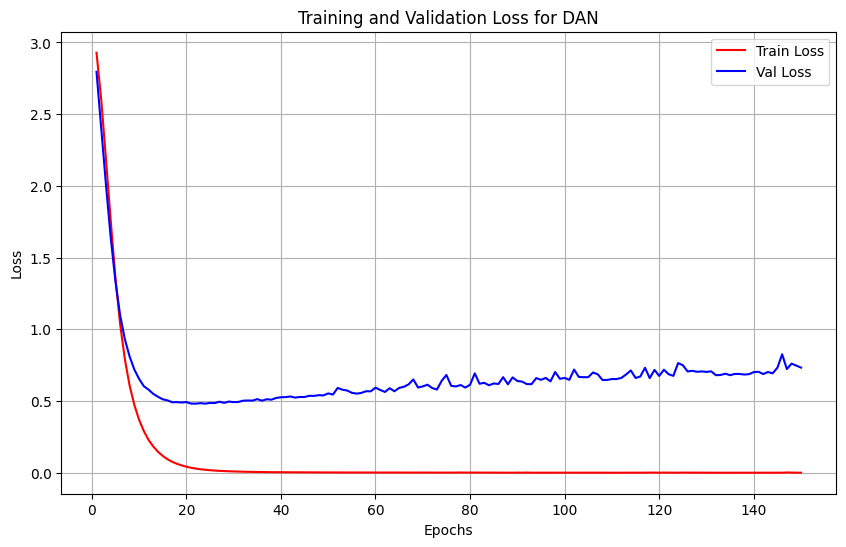

In [426]:
# DO NOT CHANGE THIS CELL - retain the outputs in submission PDF to get credits  
plot_loss(train_loss_over_time_dan, val_loss_over_time_dan, 'DAN')

### 4.3. Model Evaluation [2 points - Programming]
The final points for this will be awarded as per Gradescope's test split, which is different from the local versions. The cell below is just for a sanity check. Your metrics here may not exactly match with the ones on Gradescope, but if your model is fairly generalized, it should not be far off.
- 0 points for accuracy <= 84%
- 1 point for accuracy > 84% but <= 88%
- 2 points for accuracy > 88%

In [431]:
# DO NOT CHANGE THIS CELL
learning_rate, epochs, hidden_layer_dimensions, embedding_dim = get_hyperparams_dan()
dan_model = get_dan_model(len(train_vocab.keys()), embedding_dim, hidden_layer_dimensions).to(device)
load_checkpoint(dan_model, 'dan', map_location=device)

true, pred, val_loss = val_loop(dan_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.12it/s]

Final Validation Accuracy: 0.8795755968169762
Final Validation F1-Score: 0.8788140631346695


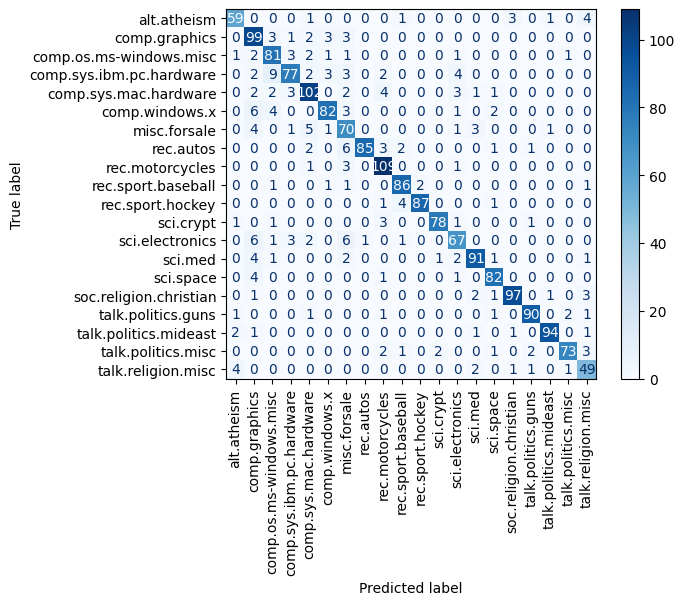

In [432]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

## 5. Attention-based Models [21 points - Programming + 9 points - Non-programming]
 In the simplest terms, attention allows a network to differentially focus on specific input words rather considering their importance equally, as done in the previous sections by averaging. For example, often times the mere presence of word "election" is enough to ascertain the category of the sentence to be politics. 

 There are various types of attention which we will dsicuss in much more depth throughout course. This section is just to provide a conceptual flavor of attention as a concept. In the below parts, you will work with three different simple types of attention. 

### 5.1. Attention-weighted NBOW [7 points - Programming + 3 points - Non-programming]



You will now define an encoder that uses a simple attention function to produce a weight for each word in the sentence followed by a sum of the attention-weighted word embeddings. Simple attention allows the model to learn a weight vector $\alpha_t$ which represents how important will different tokens in a document be.

Consider $u$ to be a single attention head (a learnable PyTorch parameter). With this,

$$ \alpha_t \varpropto \exp\{cos(u,emb(x_t))\} $$

*Note*: This needs to be normalized.

$$ h_{att} = \sum_t \alpha_t emb(x_t) $$

The probability of a data instance belonging to class $y_i$ is given by:

$$ p(y|x) = softmax(w^T h_{att}) $$

where $w \in R^d$ is a parameter vector.

In this model, the unnormalized attention weight for a word $x$ is computed using the cosine similarity between a learnable parameter $u$ and the word embedding for $x$ followed by exponentiation. To get normalized weights $\alpha_t$, normalize across all words in the sentence. Then multiply the attention weights by the word embeddings and sum the attention-weighted embeddings.

*HINT*: See if Softmax function can help with this

*Hint*: Make sure to handle the case where the input contains pad tokens.

#### 5.1.1. Model Definition [5 points - Programming]

Define your simple attention model below.

In [415]:
#export

class SimpleAttentionNBOW(nn.Module):
    """
    This class implements the Attention-weighted Neural Bag of Words model.
    """
    
    def __init__(self, vocab_size, embedding_dim, num_classes=20):
        super(SimpleAttentionNBOW, self).__init__()
        ## YOUR CODE STARTS HERE ##
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes

        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # Embedding layer
        self.attention = nn.Parameter(torch.randn(embedding_dim), requires_grad=True)  # Attention layer
        self.linear = nn.Linear(embedding_dim, num_classes)  # Linear layer for classification

        ## YOUR CODE ENDS HERE ##
    
    def forward(self, x):
        ## YOUR CODE STARTS HERE ##
        
        attn = self.get_attention_matrix(x)  # Get attention weights
        embeddings = self.get_embeddings(x)  # Get embeddings
        hidden = (embeddings * attn.unsqueeze(-1)).sum(dim=1)  # Apply attention weights
        predictions = self.linear(hidden)  # Pass through linear layer

        ## YOUR CODE ENDS HERE ##
        
        return predictions
    
    def get_embeddings(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        
        return self.embedding(x)

        ### YOUR CODE ENDS HERE ###
    
    def set_embedding_weight(self, weight):
        '''
        This function sets the embedding weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (vocab_size, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        
        self.embedding.weight = nn.Parameter(weight, requires_grad=False)

        ### YOUR CODE ENDS HERE ###
            
    def set_attention_weights(self, weight):
        '''
        This function sets the attention weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        
        self.attention = nn.Parameter(weight, requires_grad=False)

        ### YOUR CODE ENDS HERE ###
    
    def get_attention_matrix(self, x):
        '''
        This function returns the normalized attention matrix for the input x
        Args:
            x: torch.tensor of shape (BATCH_SIZE, max seq length in batch))
        Returns:
            attention_weights: torch.tensor of shape (BATCH_SIZE, max seq length in batch))
        '''
        ### YOUR CODE STARTS HERE ###
        embeddings = self.get_embeddings(x)
        attn = self.attention.expand(embeddings.size(0), embeddings.size(1), -1)
        cos_sim = torch.cosine_similarity(embeddings, attn, dim=-1)

        # Mask to ignore padding tokens
        mask = (x != 0)
        cos_sim = cos_sim.masked_fill(~mask, float('-inf'))

        return torch.softmax(cos_sim, dim=-1) * mask.float()

        ### YOUR CODE ENDS HERE ###
        

In [410]:
# local test for sanity:
# DO NOT CHANGE THIS CELL
def simple_attention_nbow_test_local_embeddings():
    model = SimpleAttentionNBOW(embedding_dim=3, vocab_size=5)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    embeddings = model.get_embeddings(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_embeddings = torch.tensor([[[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.2400, 0.2600, 0.2800],
                                        [0.0600, 0.0800, 0.1000]],

                                        [[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.0000, 0.0200, 0.0400],
                                        [0.0000, 0.0200, 0.0400]]])
    if torch.allclose(embeddings, correct_embeddings, rtol=0.001):
        print("Passed local embedding test")
    else:
        print(f"Embedding Test failed, expected value was\n{correct_embeddings}\nbut you got:\n{embeddings}")
def simple_attention_nbow_test_local_attn():
    model = SimpleAttentionNBOW(embedding_dim=3, vocab_size=5)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    model.set_attention_weights(torch.tensor([0.1, 0.2, 0.3]))
    attention_weights = model.get_attention_matrix(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_attention_weights = torch.tensor([[0.2033, 0.1995, 0.1975, 0.1964, 0.2033],
                                              [0.3387, 0.3323, 0.3290, 0.0000, 0.0000]])
    if torch.allclose(attention_weights, correct_attention_weights, rtol=0.001):
        print("Passed local Attn test")
    else:
        print(f"Attn Test failed, expected value was\n{correct_attention_weights}\nbut you got:\n{attention_weights}")

simple_attention_nbow_test_local_embeddings()
simple_attention_nbow_test_local_attn()

Passed local embedding test
Passed local Attn test


#### 5.1.2. Model Training [3 points - Non-Programming]
Assign and tune the below hyperparameters to optimize your model

In [416]:
#export
# Assign hyperparameters and training parameters
# Experiment with different values for these hyperparaters to optimize your model's performance
def get_hyperparams_simple_attention():
  ### your hyper parameters
    learning_rate = 0.001
    epochs = 100
    embedding_dim = 64
    return learning_rate, epochs, embedding_dim

In [417]:
# export
def get_simple_attention_model(vocab_size, embedding_dim):
    """
    This function returns an instance of the SimpleAttentionNBOW model. Initialize the SimpleAttentionNBOW model here and return it.
    """
    ## YOUR CODE STARTS HERE ##

    model = SimpleAttentionNBOW(vocab_size=vocab_size, embedding_dim=embedding_dim)

    ## YOUR CODE ENDS HERE ##
    return model

In [418]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, embedding_dim = get_hyperparams_simple_attention()
simple_attention_model = get_simple_attention_model(vocab_size=len(train_vocab.keys()),embedding_dim=embedding_dim).to(device)
criterion = get_criterion()
train_loss_over_time_sa = []
val_loss_over_time_sa = []
optimizer = get_optimizer(simple_attention_model, learning_rate)
for epoch in range(epochs):
    train_loss = train_loop(simple_attention_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(simple_attention_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    train_loss_over_time_sa.append(train_loss)
    val_loss_over_time_sa.append(val_loss)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")
save_checkpoint(simple_attention_model, 'simple_attention')

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.70it/s]


Epoch 1 -- Train_Loss: 2.9573628255876443 -- Val_Loss: 2.917524719238281 -- Val_Accuracy: 0.15119363395225463 -- Val_F1: 0.12720384298273663


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.25it/s]


Epoch 2 -- Train_Loss: 2.8699395979865123 -- Val_Loss: 2.8193833510080974 -- Val_Accuracy: 0.20212201591511936 -- Val_F1: 0.16960374262934966


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.31it/s]


Epoch 3 -- Train_Loss: 2.747089931520365 -- Val_Loss: 2.6830881595611573 -- Val_Accuracy: 0.28116710875331563 -- Val_F1: 0.24722684544980109


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 58.62it/s]


Epoch 4 -- Train_Loss: 2.586367651567621 -- Val_Loss: 2.517157506942749 -- Val_Accuracy: 0.36816976127320955 -- Val_F1: 0.3384755184181207


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 59.45it/s]


Epoch 5 -- Train_Loss: 2.389322113182585 -- Val_Loss: 2.3214199860890705 -- Val_Accuracy: 0.4625994694960212 -- Val_F1: 0.4346190472478238


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.96it/s]


Epoch 6 -- Train_Loss: 2.1573703763848644 -- Val_Loss: 2.097911580403646 -- Val_Accuracy: 0.5538461538461539 -- Val_F1: 0.5267372213716357


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.78it/s]


Epoch 7 -- Train_Loss: 1.9022194298647217 -- Val_Loss: 1.8619295358657837 -- Val_Accuracy: 0.6265251989389921 -- Val_F1: 0.5975983266626279


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.05it/s]


Epoch 8 -- Train_Loss: 1.6420098300707542 -- Val_Loss: 1.6285983482996622 -- Val_Accuracy: 0.6816976127320955 -- Val_F1: 0.6561911456804026


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.33it/s]


Epoch 9 -- Train_Loss: 1.3948894870483268 -- Val_Loss: 1.4177566369374592 -- Val_Accuracy: 0.7225464190981432 -- Val_F1: 0.6995908531763806


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 59.72it/s]


Epoch 10 -- Train_Loss: 1.1737082954180442 -- Val_Loss: 1.229058273633321 -- Val_Accuracy: 0.7655172413793103 -- Val_F1: 0.7531735867778269


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.97it/s]


Epoch 11 -- Train_Loss: 0.9844433634968127 -- Val_Loss: 1.0732037742932639 -- Val_Accuracy: 0.7920424403183024 -- Val_F1: 0.783195161942998


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.20it/s]


Epoch 12 -- Train_Loss: 0.8272344207359572 -- Val_Loss: 0.9451207478841146 -- Val_Accuracy: 0.8148541114058355 -- Val_F1: 0.8081691611690621


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.91it/s]


Epoch 13 -- Train_Loss: 0.6986570499711118 -- Val_Loss: 0.8374353289604187 -- Val_Accuracy: 0.8291777188328913 -- Val_F1: 0.8251694570098118


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.68it/s]


Epoch 14 -- Train_Loss: 0.5938697666940043 -- Val_Loss: 0.7495859940846761 -- Val_Accuracy: 0.839787798408488 -- Val_F1: 0.8370304814097139


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.06it/s]


Epoch 15 -- Train_Loss: 0.5084072528249126 -- Val_Loss: 0.6823624809583028 -- Val_Accuracy: 0.8594164456233422 -- Val_F1: 0.8566255601151781


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.21it/s]


Epoch 16 -- Train_Loss: 0.43849298534757 -- Val_Loss: 0.6242287278175354 -- Val_Accuracy: 0.8673740053050398 -- Val_F1: 0.8650591040186286


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.46it/s]


Epoch 17 -- Train_Loss: 0.38063904441009133 -- Val_Loss: 0.5740968545277914 -- Val_Accuracy: 0.8721485411140584 -- Val_F1: 0.8697940582860971


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 58.90it/s]


Epoch 18 -- Train_Loss: 0.3321229185340768 -- Val_Loss: 0.5341886719067891 -- Val_Accuracy: 0.8779840848806366 -- Val_F1: 0.8755635697652489


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.34it/s]


Epoch 19 -- Train_Loss: 0.29159470104565055 -- Val_Loss: 0.5012789448102315 -- Val_Accuracy: 0.8838196286472149 -- Val_F1: 0.8807606808240396


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.07it/s]


Epoch 20 -- Train_Loss: 0.25698491943589713 -- Val_Loss: 0.4711530884106954 -- Val_Accuracy: 0.8870026525198939 -- Val_F1: 0.8848622803343666


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.66it/s]


Epoch 21 -- Train_Loss: 0.227507201291747 -- Val_Loss: 0.44928553303082785 -- Val_Accuracy: 0.8912466843501327 -- Val_F1: 0.8894396857675817


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.30it/s]


Epoch 22 -- Train_Loss: 0.20209235091835764 -- Val_Loss: 0.42948818802833555 -- Val_Accuracy: 0.8917771883289125 -- Val_F1: 0.8895800856620084


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.89it/s]


Epoch 23 -- Train_Loss: 0.17996305656635156 -- Val_Loss: 0.40624637007713316 -- Val_Accuracy: 0.8954907161803713 -- Val_F1: 0.8932507502180206


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.29it/s]


Epoch 24 -- Train_Loss: 0.16052140005059162 -- Val_Loss: 0.3924451569716136 -- Val_Accuracy: 0.9007957559681697 -- Val_F1: 0.8985629388799456


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.87it/s]


Epoch 25 -- Train_Loss: 0.1435839308394214 -- Val_Loss: 0.3782849729061127 -- Val_Accuracy: 0.903448275862069 -- Val_F1: 0.9010530649915266


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.00it/s]


Epoch 26 -- Train_Loss: 0.1287538473636417 -- Val_Loss: 0.36697494784990947 -- Val_Accuracy: 0.906631299734748 -- Val_F1: 0.9044010408142077


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.99it/s]


Epoch 27 -- Train_Loss: 0.11551379406098593 -- Val_Loss: 0.35361111760139463 -- Val_Accuracy: 0.9076923076923077 -- Val_F1: 0.9052181043130278


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.14it/s]


Epoch 28 -- Train_Loss: 0.10375668304198879 -- Val_Loss: 0.34159403840700786 -- Val_Accuracy: 0.9098143236074271 -- Val_F1: 0.9069006642243448


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.01it/s]


Epoch 29 -- Train_Loss: 0.09351520035100186 -- Val_Loss: 0.33533677061398826 -- Val_Accuracy: 0.9124668435013262 -- Val_F1: 0.9096987474721739


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.11it/s]


Epoch 30 -- Train_Loss: 0.08421226455119707 -- Val_Loss: 0.32859778106212617 -- Val_Accuracy: 0.916710875331565 -- Val_F1: 0.9140168127683358


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.96it/s]


Epoch 31 -- Train_Loss: 0.07613121484548359 -- Val_Loss: 0.3205500036478043 -- Val_Accuracy: 0.9183023872679045 -- Val_F1: 0.9159068373666794


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.88it/s]


Epoch 32 -- Train_Loss: 0.06860791083614705 -- Val_Loss: 0.3164632429679235 -- Val_Accuracy: 0.9183023872679045 -- Val_F1: 0.9161985603411573


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.82it/s]


Epoch 33 -- Train_Loss: 0.06197664293192201 -- Val_Loss: 0.30832507610321047 -- Val_Accuracy: 0.9214854111405836 -- Val_F1: 0.9189299172471721


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.29it/s]


Epoch 34 -- Train_Loss: 0.05604735379880768 -- Val_Loss: 0.3024759521087011 -- Val_Accuracy: 0.9220159151193634 -- Val_F1: 0.9196467353861342


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.32it/s]


Epoch 35 -- Train_Loss: 0.05074457795816963 -- Val_Loss: 0.2983814050753911 -- Val_Accuracy: 0.9220159151193634 -- Val_F1: 0.9196208959535712


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.71it/s]


Epoch 36 -- Train_Loss: 0.04602142825912116 -- Val_Loss: 0.2934261570374171 -- Val_Accuracy: 0.9214854111405836 -- Val_F1: 0.9192668963278438


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.75it/s]


Epoch 37 -- Train_Loss: 0.041657237872733906 -- Val_Loss: 0.2894822428623835 -- Val_Accuracy: 0.9230769230769231 -- Val_F1: 0.9210171347209541


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.58it/s]


Epoch 38 -- Train_Loss: 0.03793478956035638 -- Val_Loss: 0.28723191122214 -- Val_Accuracy: 0.9230769230769231 -- Val_F1: 0.9210696092360937


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.28it/s]


Epoch 39 -- Train_Loss: 0.03445303833143691 -- Val_Loss: 0.2866384983062744 -- Val_Accuracy: 0.9236074270557029 -- Val_F1: 0.9216794928559761


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.97it/s]


Epoch 40 -- Train_Loss: 0.03129196239603778 -- Val_Loss: 0.2783140649398168 -- Val_Accuracy: 0.9230769230769231 -- Val_F1: 0.9216548900771857


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.18it/s]


Epoch 41 -- Train_Loss: 0.028549858226867047 -- Val_Loss: 0.27712501883506774 -- Val_Accuracy: 0.9230769230769231 -- Val_F1: 0.9214414120033773


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.33it/s]


Epoch 42 -- Train_Loss: 0.026004548168788524 -- Val_Loss: 0.27572725315888724 -- Val_Accuracy: 0.9241379310344827 -- Val_F1: 0.9221680251132234


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.20it/s]


Epoch 43 -- Train_Loss: 0.02373620406014182 -- Val_Loss: 0.27139588991800945 -- Val_Accuracy: 0.9246684350132626 -- Val_F1: 0.922833291097966


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.83it/s]


Epoch 44 -- Train_Loss: 0.021727787899011274 -- Val_Loss: 0.2698826422293981 -- Val_Accuracy: 0.9241379310344827 -- Val_F1: 0.922247741612695


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.08it/s]


Epoch 45 -- Train_Loss: 0.019853353113630564 -- Val_Loss: 0.26929385364055636 -- Val_Accuracy: 0.9246684350132626 -- Val_F1: 0.922742666228309


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.69it/s]


Epoch 46 -- Train_Loss: 0.018208545608982697 -- Val_Loss: 0.2695710092782974 -- Val_Accuracy: 0.9241379310344827 -- Val_F1: 0.9222625484223368


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.07it/s]


Epoch 47 -- Train_Loss: 0.016663085606138585 -- Val_Loss: 0.26468153993288673 -- Val_Accuracy: 0.9251989389920424 -- Val_F1: 0.9235917089317411


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.10it/s]


Epoch 48 -- Train_Loss: 0.015308477339666273 -- Val_Loss: 0.26195550163586934 -- Val_Accuracy: 0.9241379310344827 -- Val_F1: 0.9222191777712514


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.11it/s]


Epoch 49 -- Train_Loss: 0.01407040901071692 -- Val_Loss: 0.26736733118693035 -- Val_Accuracy: 0.9246684350132626 -- Val_F1: 0.922765507753384


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.07it/s]


Epoch 50 -- Train_Loss: 0.012968181679814549 -- Val_Loss: 0.26025819083054863 -- Val_Accuracy: 0.9251989389920424 -- Val_F1: 0.9235969074029583


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.92it/s]


Epoch 51 -- Train_Loss: 0.011951719907949031 -- Val_Loss: 0.2594836672147115 -- Val_Accuracy: 0.9246684350132626 -- Val_F1: 0.9228127783010951


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.91it/s]


Epoch 52 -- Train_Loss: 0.010998582818655896 -- Val_Loss: 0.25810154577096306 -- Val_Accuracy: 0.9262599469496021 -- Val_F1: 0.9246361332365737


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.82it/s]


Epoch 53 -- Train_Loss: 0.010157995952009145 -- Val_Loss: 0.25901341438293457 -- Val_Accuracy: 0.9262599469496021 -- Val_F1: 0.9246075577348953


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.45it/s]


Epoch 54 -- Train_Loss: 0.00940359959189417 -- Val_Loss: 0.2568948447704315 -- Val_Accuracy: 0.926790450928382 -- Val_F1: 0.9250741108861776


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.44it/s]


Epoch 55 -- Train_Loss: 0.00867086366387242 -- Val_Loss: 0.2575330793857574 -- Val_Accuracy: 0.9262599469496021 -- Val_F1: 0.9242009713660007


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.17it/s]


Epoch 56 -- Train_Loss: 0.008077286266706 -- Val_Loss: 0.25616923669974007 -- Val_Accuracy: 0.926790450928382 -- Val_F1: 0.9248096982897703


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.57it/s]


Epoch 57 -- Train_Loss: 0.007491846880638751 -- Val_Loss: 0.25309788088003793 -- Val_Accuracy: 0.926790450928382 -- Val_F1: 0.9250927991571747


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.20it/s]


Epoch 58 -- Train_Loss: 0.006943401298485696 -- Val_Loss: 0.25614436020453774 -- Val_Accuracy: 0.9257294429708223 -- Val_F1: 0.9239670305642097


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.64it/s]


Epoch 59 -- Train_Loss: 0.006483118053746678 -- Val_Loss: 0.2522599766651789 -- Val_Accuracy: 0.9278514588859417 -- Val_F1: 0.9259498291874898


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.67it/s]


Epoch 60 -- Train_Loss: 0.006041822288090647 -- Val_Loss: 0.2536653493841489 -- Val_Accuracy: 0.9257294429708223 -- Val_F1: 0.9236700055137191


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.17it/s]


Epoch 61 -- Train_Loss: 0.005617876754189699 -- Val_Loss: 0.2510090500116348 -- Val_Accuracy: 0.9273209549071618 -- Val_F1: 0.9252723003118163


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.02it/s]


Epoch 62 -- Train_Loss: 0.005260831585659062 -- Val_Loss: 0.25320295890172323 -- Val_Accuracy: 0.9278514588859417 -- Val_F1: 0.9258609541487104


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.57it/s]


Epoch 63 -- Train_Loss: 0.004899949857459987 -- Val_Loss: 0.2533693457643191 -- Val_Accuracy: 0.9283819628647215 -- Val_F1: 0.9264027693217098


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.83it/s]


Epoch 64 -- Train_Loss: 0.004620432979979758 -- Val_Loss: 0.2500264644622803 -- Val_Accuracy: 0.9278514588859417 -- Val_F1: 0.925906874412022


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.57it/s]


Epoch 65 -- Train_Loss: 0.004316254923420059 -- Val_Loss: 0.25157414575417836 -- Val_Accuracy: 0.9283819628647215 -- Val_F1: 0.9264345369496055


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.20it/s]


Epoch 66 -- Train_Loss: 0.004029291044620765 -- Val_Loss: 0.25479330867528915 -- Val_Accuracy: 0.9283819628647215 -- Val_F1: 0.9264804572129168


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.83it/s]


Epoch 67 -- Train_Loss: 0.0037915380691351777 -- Val_Loss: 0.25144376456737516 -- Val_Accuracy: 0.9289124668435014 -- Val_F1: 0.9269786793895769


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.28it/s]


Epoch 68 -- Train_Loss: 0.003587105469304626 -- Val_Loss: 0.2492157369852066 -- Val_Accuracy: 0.9278514588859417 -- Val_F1: 0.926053144840678


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.84it/s]


Epoch 69 -- Train_Loss: 0.0033530688073123032 -- Val_Loss: 0.24851473917563757 -- Val_Accuracy: 0.9283819628647215 -- Val_F1: 0.9265804258047823


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 58.69it/s]


Epoch 70 -- Train_Loss: 0.003165932048617278 -- Val_Loss: 0.2543840065598488 -- Val_Accuracy: 0.9289124668435014 -- Val_F1: 0.9270222685310398


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 59.84it/s]


Epoch 71 -- Train_Loss: 0.0029793255104115074 -- Val_Loss: 0.24993529468774794 -- Val_Accuracy: 0.9294429708222812 -- Val_F1: 0.927436953549347


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.82it/s]


Epoch 72 -- Train_Loss: 0.002797880552322367 -- Val_Loss: 0.25210657715797424 -- Val_Accuracy: 0.9278514588859417 -- Val_F1: 0.9260070804754129


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.76it/s]


Epoch 73 -- Train_Loss: 0.002652916669553556 -- Val_Loss: 0.24741552223761876 -- Val_Accuracy: 0.9294429708222812 -- Val_F1: 0.9277620906963587


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.22it/s]


Epoch 74 -- Train_Loss: 0.002523870072209166 -- Val_Loss: 0.24890588621298473 -- Val_Accuracy: 0.9289124668435014 -- Val_F1: 0.9272905714625983


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.28it/s]


Epoch 75 -- Train_Loss: 0.002344701928481207 -- Val_Loss: 0.24940834840138754 -- Val_Accuracy: 0.9294429708222812 -- Val_F1: 0.927772037190708


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.26it/s]


Epoch 76 -- Train_Loss: 0.002234999638966332 -- Val_Loss: 0.25019525190194447 -- Val_Accuracy: 0.9294429708222812 -- Val_F1: 0.9277864663722862


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.20it/s]


Epoch 77 -- Train_Loss: 0.002099659139984998 -- Val_Loss: 0.2567596048116684 -- Val_Accuracy: 0.9294429708222812 -- Val_F1: 0.9277801996878084


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.57it/s]


Epoch 78 -- Train_Loss: 0.002008429305209636 -- Val_Loss: 0.2502413998047511 -- Val_Accuracy: 0.9289124668435014 -- Val_F1: 0.9271403292984273


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.90it/s]


Epoch 79 -- Train_Loss: 0.0019047760085984116 -- Val_Loss: 0.25337011416753136 -- Val_Accuracy: 0.9289124668435014 -- Val_F1: 0.9273887792021933


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.21it/s]


Epoch 80 -- Train_Loss: 0.0018015986908290346 -- Val_Loss: 0.25198702812194823 -- Val_Accuracy: 0.9310344827586207 -- Val_F1: 0.929271063400733


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.92it/s]


Epoch 81 -- Train_Loss: 0.0017136778426948556 -- Val_Loss: 0.2506238038341204 -- Val_Accuracy: 0.9289124668435014 -- Val_F1: 0.9271894396500772


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.82it/s]


Epoch 82 -- Train_Loss: 0.001637401366093338 -- Val_Loss: 0.2524177004893621 -- Val_Accuracy: 0.9283819628647215 -- Val_F1: 0.9267587482289189


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.68it/s]


Epoch 83 -- Train_Loss: 0.001565809337958946 -- Val_Loss: 0.25219296564658483 -- Val_Accuracy: 0.929973474801061 -- Val_F1: 0.9280704932155134


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.59it/s]


Epoch 84 -- Train_Loss: 0.0014927576831739269 -- Val_Loss: 0.2521121084690094 -- Val_Accuracy: 0.9278514588859417 -- Val_F1: 0.926231045820332


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.57it/s]


Epoch 85 -- Train_Loss: 0.0014053738717447525 -- Val_Loss: 0.25190434356530506 -- Val_Accuracy: 0.9283819628647215 -- Val_F1: 0.9266265877888665


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.59it/s]


Epoch 86 -- Train_Loss: 0.001345843797642343 -- Val_Loss: 0.2531834890445073 -- Val_Accuracy: 0.929973474801061 -- Val_F1: 0.9284492057107026


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.62it/s]


Epoch 87 -- Train_Loss: 0.0012751636776078682 -- Val_Loss: 0.258166566491127 -- Val_Accuracy: 0.9289124668435014 -- Val_F1: 0.9274084904759967


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.71it/s]


Epoch 88 -- Train_Loss: 0.0012216940724440867 -- Val_Loss: 0.2517597715059916 -- Val_Accuracy: 0.9294429708222812 -- Val_F1: 0.9279109919179384


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.55it/s]


Epoch 89 -- Train_Loss: 0.0011757893368929341 -- Val_Loss: 0.25336023767789206 -- Val_Accuracy: 0.9315649867374005 -- Val_F1: 0.930033726753264


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.37it/s]


Epoch 90 -- Train_Loss: 0.001130413885328966 -- Val_Loss: 0.25530189176400503 -- Val_Accuracy: 0.929973474801061 -- Val_F1: 0.9283676819196753


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.59it/s]


Epoch 91 -- Train_Loss: 0.0010788852920641302 -- Val_Loss: 0.2545107473929723 -- Val_Accuracy: 0.9305039787798408 -- Val_F1: 0.9288597860244403


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 56.85it/s]


Epoch 92 -- Train_Loss: 0.0010092111513555302 -- Val_Loss: 0.2532398541768392 -- Val_Accuracy: 0.9289124668435014 -- Val_F1: 0.9274322887600602


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.51it/s]


Epoch 93 -- Train_Loss: 0.0009601175071280924 -- Val_Loss: 0.2608705659707387 -- Val_Accuracy: 0.929973474801061 -- Val_F1: 0.9284693422663128


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.83it/s]


Epoch 94 -- Train_Loss: 0.0009431687101792796 -- Val_Loss: 0.25776471197605133 -- Val_Accuracy: 0.9310344827586207 -- Val_F1: 0.929508919612906


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 58.33it/s]


Epoch 95 -- Train_Loss: 0.0008859145415599568 -- Val_Loss: 0.25488982995351156 -- Val_Accuracy: 0.9315649867374005 -- Val_F1: 0.9300685026825338


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.71it/s]


Epoch 96 -- Train_Loss: 0.0008632673986031184 -- Val_Loss: 0.2538814922173818 -- Val_Accuracy: 0.9305039787798408 -- Val_F1: 0.9290180415185721


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 61.13it/s]


Epoch 97 -- Train_Loss: 0.0008168074295469323 -- Val_Loss: 0.25624798734982807 -- Val_Accuracy: 0.9305039787798408 -- Val_F1: 0.9290231575908707


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.61it/s]


Epoch 98 -- Train_Loss: 0.0007888956125667793 -- Val_Loss: 0.2566897471745809 -- Val_Accuracy: 0.9310344827586207 -- Val_F1: 0.9295422010897832


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.52it/s]


Epoch 99 -- Train_Loss: 0.0007555859370090036 -- Val_Loss: 0.257276064902544 -- Val_Accuracy: 0.9310344827586207 -- Val_F1: 0.9296354127901569


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 60.44it/s]

Epoch 100 -- Train_Loss: 0.0007407042483741938 -- Val_Loss: 0.25926212072372434 -- Val_Accuracy: 0.9305039787798408 -- Val_F1: 0.9290180415185721
Checkpoint saved to /home/jblevins32/NLP_HW1/model_weights/checkpoint_simple_attention_ce.pt


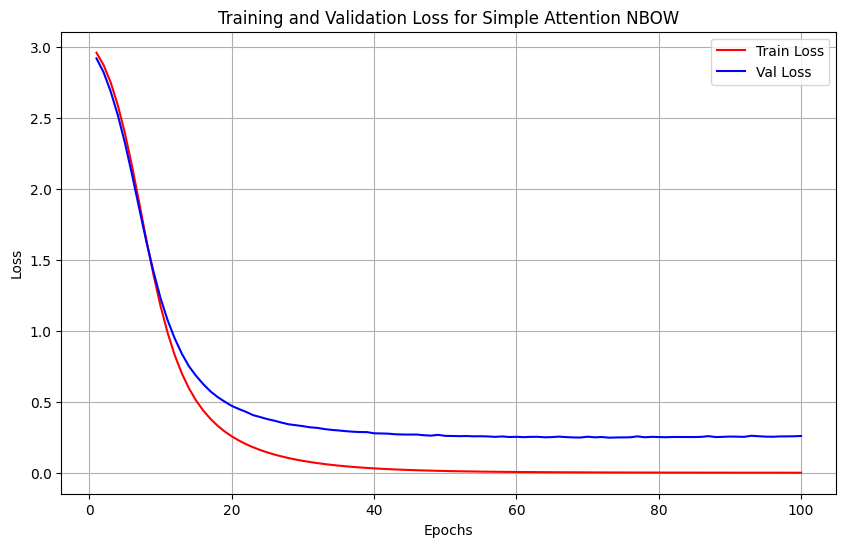

In [419]:
# DO NOT CHANGE THIS CELL - retain the outputs in submission PDF to get credits   
plot_loss(train_loss_over_time_sa, val_loss_over_time_sa, 'Simple Attention NBOW')

#### 5.1.3. Model Evaluation [2 points - Programming]
The final points for this will be awarded as per Gradescope's test split, which is different from the local versions. The cell below is just for a sanity check. Your metrics here may not exactly match with the ones on Gradescope, but if your model is fairly generalized, it should not be far off.
- 0 points for accuracy <= 85%
- 1 point for accuracy > 85% but <= 90%
- 2 points for accuracy > 90%

In [420]:
# DO NOT CHANGE THIS CELL
learning_rate, epochs, embedding_dim = get_hyperparams_simple_attention()
simple_attention_model = get_simple_attention_model(vocab_size=len(train_vocab.keys()),embedding_dim=embedding_dim).to(device)
load_checkpoint(simple_attention_model, 'simple_attention', map_location=device)

true, pred, val_loss = val_loop(simple_attention_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 59.24it/s]

Final Validation Accuracy: 0.9305039787798408
Final Validation F1-Score: 0.9290180415185721


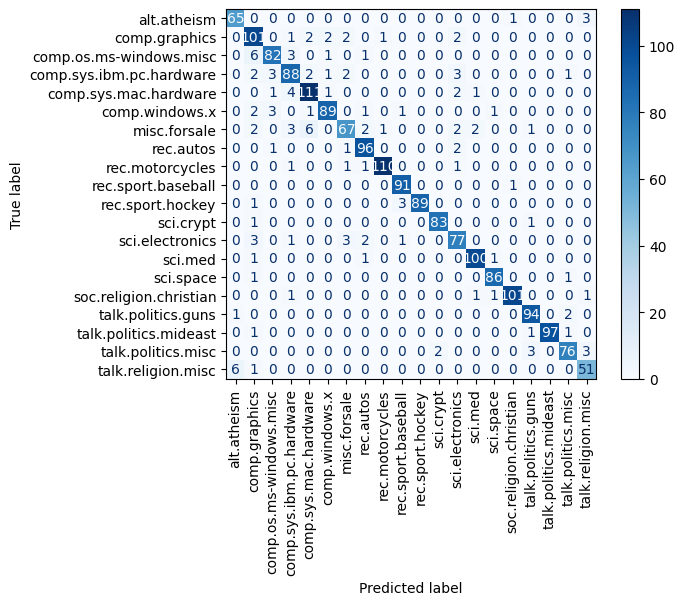

In [421]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

### 5.2. MultiHead Attention NBOW [7 points - Programming + 3 points - Non-programming]

The prior model only uses a single attention function. In this section, you will implement a multi-head attention model. You will use $k$ attention heads, each with its own parameters $u_i \in R^d$ ($\forall i \in [1..k]$) and a single large vector before the classification to weight them all together $w \in R^{d \cdot k}$. 

$$ \alpha_{t,i} \varpropto \exp\{cos(u_i,emb(x_t))\} $$

$$ h_{att}(i) = \sum_t\alpha_{t,i} emb(x_t) $$

With the probability of a task instance belonging to class $y_i$ is given by:

$$ p(y|x) = softmax(w^T [h_{att}(1), h_{att}(2), ..., h_{att}(k)]) $$

where [a,b] is the concatenation of vectors $a$ and $b$, into a single taller vector.

#### 5.2.1. Model Definition [5 points - Programming]

Define your Multi-head attention below

In [ ]:
#export

class MultiHeadAttentionNBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_classes=20):
        ## YOUR CODE STARTS HERE ##
        super(MultiHeadAttentionNBOW, self).__init__()
        pass # remove this when you add your implementation      
        ## YOUR CODE ENDS HERE ##
    def forward(self, x):
        ## YOUR CODE STARTS HERE ##
        pass # remove this when you add your implementation
        ## YOUR CODE ENDS HERE ##


    def get_embeddings(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        pass # remove this when you add your implementation
        ### YOUR CODE ENDS HERE ###
    
    def set_embedding_weight(self, weight):
        '''
        This function sets the embedding weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (vocab_size, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        pass # remove this when you add your implementation
        ### YOUR CODE ENDS HERE ###
            
    def set_attention_weights(self, weight):
        '''
        This function sets the attention weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (num_heads, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        pass # remove this when you add your implementation
        ### YOUR CODE ENDS HERE ###
    
    def get_attention_matrix(self, x):
        '''
        This function returns the normalized attention matrix for the input x
        Args:
            x: torch.tensor of shape (BATCH_SIZE, max seq length in batch))
        Returns:
            attention_weights: torch.tensor of shape (BATCH_SIZE, max seq length in batch, num_heads))
        '''
        ### YOUR CODE STARTS HERE ###
        pass # remove this when you add your implementation
        ### YOUR CODE ENDS HERE ###

In [402]:
# local test for sanity:
# DO NOT CHANGE THIS CELL
def multihead_attn_nbow_test_local():
    embedding_dim = 10
    vocab_size = 10
    num_heads = 3
    model = MultiHeadAttentionNBOW(vocab_size=vocab_size, embedding_dim=embedding_dim, num_heads=num_heads)
    for _, module in model.named_parameters():
        if hasattr(module, "data"):
            nn.init.constant_(module, 0.3)
    input = torch.tensor([[1,2,3,4,0,0,0],
                          [5,6,7,0,0,0,0]]) % vocab_size
    expected_result = torch.tensor(
        [[2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000,
         2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000,
         2.7000, 2.7000],
        [2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000,
         2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000,
         2.7000, 2.7000]]
    )
    with torch.no_grad():
        local_result = model(input)
    if torch.allclose(expected_result, local_result, rtol=0.001):
        print("Passed local check")
    else:
        print(f"Test failed, expected value was\n{expected_result}\nbut you got:\n{local_result}")

# local test for sanity:
def multi_attention_nbow_test_local_embeddings():
    model = MultiHeadAttentionNBOW(embedding_dim=3, vocab_size=5, num_heads=4)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    embeddings = model.get_embeddings(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_embeddings = torch.tensor([[[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.2400, 0.2600, 0.2800],
                                        [0.0600, 0.0800, 0.1000]],

                                        [[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.0000, 0.0200, 0.0400],
                                        [0.0000, 0.0200, 0.0400]]])
    if torch.allclose(embeddings, correct_embeddings, rtol=0.001):
        print("Passed local embedding test")
    else:
        print(f"Embedding Test failed, expected value was\n{correct_embeddings}\nbut you got:\n{embeddings}")
def multi_attention_nbow_test_local_attn():
    model = MultiHeadAttentionNBOW(embedding_dim=3, vocab_size=5, num_heads=4)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    model.set_attention_weights(torch.tensor([[0.1, 0.2, 0.3],[0.1, 0.2, 0.3],[0.2, 0.2, 0.2],[0, 0.3, 0.3]]))
    attention_weights = model.get_attention_matrix(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_attention_weights = torch.tensor([[[0.2033, 0.2033, 0.1981, 0.2052],
                                                [0.1995, 0.1995, 0.2007, 0.1990],
                                                [0.1975, 0.1975, 0.2014, 0.1961],
                                                [0.1964, 0.1964, 0.2017, 0.1945],
                                                [0.2033, 0.2033, 0.1981, 0.2052]],

                                                [[0.3387, 0.3387, 0.3300, 0.3419],
                                                [0.3323, 0.3323, 0.3344, 0.3314],
                                                [0.3290, 0.3290, 0.3356, 0.3267],
                                                [0.0000, 0.0000, 0.0000, 0.0000],
                                                [0.0000, 0.0000, 0.0000, 0.0000]]])
    if torch.allclose(attention_weights, correct_attention_weights, rtol=0.001):
        print("Passed local Attn test")
    else:
        print(f"Attn Test failed, expected value was\n{correct_attention_weights}\nbut you got:\n{attention_weights}")

multi_attention_nbow_test_local_embeddings()
multi_attention_nbow_test_local_attn()
multihead_attn_nbow_test_local()

NameError: name 'MultiHeadAttentionNBOW' is not defined

#### 5.2.2. Model Training [3 points - Non-Programming]

Assign and tune the below hyperparameters to optimize your model

In [ ]:
#export
# Assign hyperparameters and training parameters
# Experiment with different values for these hyperparaters to optimize your model's performance
def get_hyperparams_multihead():
    learning_rate = None
    epochs = None
    num_heads = None
    embedding_dim = None
    return learning_rate, epochs, num_heads, embedding_dim

In [ ]:
#export
def get_multihead_attention_model(vocab_size, embedding_dim, num_heads):
    """
    This function returns an instance of the MultiHeadAttentionNBOW model. Initialize the MultiHeadAttentionNBOW model here and return it.
    """
    model = None
    ## YOUR CODE STARTS HERE ##

    ## YOUR CODE ENDS HERE ##
    return model

In [ ]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, num_heads, embedding_dim = get_hyperparams_multihead()
multihead_attention_model = get_multihead_attention_model(vocab_size=len(train_vocab.keys()),embedding_dim=embedding_dim, num_heads=num_heads).to(device)
criterion = get_criterion()
optimizer = get_optimizer(multihead_attention_model, learning_rate)
train_loss_over_time_ma = []
val_loss_over_time_ma = []
for epoch in range(epochs):
    train_loss = train_loop(multihead_attention_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(multihead_attention_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    train_loss_over_time_ma.append(train_loss)
    val_loss_over_time_ma.append(val_loss)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")
save_checkpoint(multihead_attention_model, 'multihead_attention')

In [ ]:
# DO NOT CHANGE THIS CELL - retain the outputs in submission PDF for credits 
plot_loss(train_loss_over_time_ma, val_loss_over_time_ma, 'Multihead Attention NBOW')

#### 5.2.3. Model Evaluation [2 points - Programming]
The final points for this will be awarded as per Gradescope's test split, which is different from the local versions. The cell below is just for a sanity check. Your metrics here may not exactly match with the ones on Gradescope, but if your model is fairly generalized, it should not be far off.
- 0 points for accuracy <= 85%
- 1 point for accuracy > 85% but <= 90%
- 2 points for accuracy > 90%

In [ ]:
# DO NOT CHANGE THIS CELL
learning_rate, epochs, num_heads, embedding_dim = get_hyperparams_multihead()
multihead_attention_model = get_multihead_attention_model(vocab_size=len(train_vocab.keys()),embedding_dim=embedding_dim, num_heads=num_heads).to(device)
load_checkpoint(multihead_attention_model, 'multihead_attention')

true, pred, val_loss = val_loop(multihead_attention_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

In [ ]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

### 5.3. Self-Attention NBOW [7 points - Programming + 3 points - Non-programming]

Self-attention is a mechanism in neural networks that enables each element in a sequence to consider and weigh the importance of every other element. This facilitates a more nuanced and context-aware representation of the sequence, greatly enhancing the capabilities of models in tasks involving sequential data, particularly in NLP. It has gained prominence with the introduction and success of Transformer models, like BERT, GPT (including GPT-3), and others. This is not a full-fledged implementation of it, but instead a conceptual flavor of the mechanism.

We will now define an encoder that uses a simple form of self-attention when producing attention weights for each word in the sentence:
$$a_{ts} = emb(x_t)^Temb(x_s)$$
$$α_t \propto exp(\sum_s a_{ts})$$
$$h_{self} = \sum α_temb(x_t)$$
Then, the probability of a class is given by
$$softmax(w^Th_{self})$$
The unnormalized attention weight for a word $x$ is computed using the dot product between its embedding and those for all other words in the sentence, followed by a summation and exponentiation. Unlike the model in Section 5.1., this model does not introduce any new parameters for computing the attention function, simply using the same word embeddings for the attention. Therefore, this model has the same number of parameters as the model in Section 2.
For improved stability, we can also add a “residual connection”, which would change Eq. 1 to
$$softmax(w^T(h_{self} + h_{avg}))$$
where $h_{avg}$ is computed as in Section 2 (though using the same word embeddings as in $h_{self}$).


#### 5.3.1. Model Definition [5 points - Programming]
Define your self attention model below

In [ ]:
#export
class SelfAttentionNBOW(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, num_classes=20):
        super(SelfAttentionNBOW, self).__init__()
        # YOUR CODE STARTS HERE
        pass # remove this when you add your implementation        
        # YOUR CODE ENDS HERE

    def forward(self, x):
        # YOUR CODE STARTS HERE
        pass # remove this when you add your implementation       
        # YOUR CODE ENDS HERE
    def get_embeddings(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        pass # remove this when you add your implementation
        ### YOUR CODE ENDS HERE ###
    def set_embedding_weight(self, weight):
        '''
        This function sets the embedding weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (vocab_size, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        pass # remove this when you add your implementation
        ### YOUR CODE ENDS HERE ###
    def get_attention_matrix(self, x):
        '''
        This function returns the normalized attention matrix for the input x
        Args:
            x: torch.tensor of shape (BATCH_SIZE, max seq length in batch)
        Returns:
            attention_weights: torch.tensor of shape (BATCH_SIZE, max seq length in batch, max seq length in batch)
        '''
        ### YOUR CODE STARTS HERE ###
        pass # remove this when you add your implementation
        ### YOUR CODE ENDS HERE ###
    

In [401]:
# local test for sanity:
def self_attention_nbow_test_local():
    model = SelfAttentionNBOW(vocab_size=10, embedding_dim=10)
    for _, module in model.named_parameters():
        if hasattr(module, "data"):
            nn.init.constant_(module, 0.3)
    input = torch.tensor([[1,2,3,4,0,0,0],
                          [5,6,7,0,0,0,0]]) % 10
    
    expected_result = torch.tensor(
        [[1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000,
         1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000,
         1.8000, 1.8000],
        [1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000,
         1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000,
         1.8000, 1.8000]]
    )
    with torch.no_grad():
        local_result = model(input)
    if torch.allclose(expected_result, local_result, rtol=0.001):
        print("Passed local check")
    else:
        print(f"Test failed, expected value was\n{expected_result}\nbut you got:\n{local_result}")

def self_attention_nbow_test_local_embeddings():
    model = SelfAttentionNBOW(vocab_size=5, embedding_dim=3)
    model.set_embedding_weight(torch.arange(15).reshape(5, 3) / 50)
    embeddings = model.get_embeddings(torch.tensor([[1, 2, 3, 4, 1], [1, 2, 3, 0, 0]]))
    correct_embeddings = torch.tensor([[[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.2400, 0.2600, 0.2800],
                                        [0.0600, 0.0800, 0.1000]],

                                        [[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.0000, 0.0200, 0.0400],
                                        [0.0000, 0.0200, 0.0400]]])
    if torch.allclose(embeddings, correct_embeddings, rtol=0.001):
        print("Passed local embedding test")
    else:
        print(f"Embedding Test failed, expected value was\n{correct_embeddings}\nbut you got:\n{embeddings}")

def self_attention_nbow_test_local_attn():
    model = SelfAttentionNBOW(vocab_size=5, embedding_dim=3)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    attention_weights = model.get_attention_matrix(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_attention_weights = torch.tensor([[0.1675, 0.1921, 0.2203, 0.2526, 0.1675],
        [0.3085, 0.3327, 0.3588, 0.0000, 0.0000]])
    if torch.allclose(attention_weights, correct_attention_weights, rtol=0.001):
        print("Passed local Attn test")
    else:
        print(f"Attn Test failed, expected value was\n{correct_attention_weights}\nbut you got:\n{attention_weights}")
self_attention_nbow_test_local()
self_attention_nbow_test_local_embeddings()
self_attention_nbow_test_local_attn()


NameError: name 'SelfAttentionNBOW' is not defined

In [ ]:
#export
def get_self_attention_model(vocab_size, embedding_dim):
    """
    This function returns an instance of the Self Attention model. Initialize the Self Attention model here and return it.
    """
    model = None
    ## YOUR CODE STARTS HERE ##

    ## YOUR CODE ENDS HERE ##
    return model

#### 5.3.2. Model Training [3 points - Non-Programming]
Assign and tune the below hyperparameters to optimize your model

In [ ]:
#export
# Assign hyperparameters and training parameters
# Experiment with different values for these hyperparaters to optimize your model's performance
def get_hyperparams_self_attn():
    learning_rate = None
    epochs = None
    embedding_dim = None
    return learning_rate, epochs, embedding_dim

In [ ]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell 
learning_rate, epochs, embedding_dim = get_hyperparams_self_attn()
self_attention_model = get_self_attention_model(len(train_vocab.keys()),embedding_dim).to(device)
criterion = get_criterion()
optimizer = get_optimizer(self_attention_model, learning_rate)
train_loss_over_time_sea = []
val_loss_over_time_sea = []
for epoch in range(epochs):
    train_loss = train_loop(self_attention_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(self_attention_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    train_loss_over_time_sea.append(train_loss)
    val_loss_over_time_sea.append(val_loss)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")
save_checkpoint(self_attention_model, 'self_attention')

In [ ]:
# DO NOT CHANGE THIS CELL - retain the outputs in submission PDF for credits 
plot_loss(train_loss_over_time_sea, val_loss_over_time_sea, 'Self Attention NBOW')

#### 5.3.3. Model Evaluation Model Evaluation [2 points - Programming]
The final points for this will be awarded as per Gradescope's test split, which is different from the local versions. The cell below is just for a sanity check. Your metrics here may not exactly match with the ones on Gradescope, but if your model is fairly generalized, it should not be far off.
- 0 points for accuracy <= 85%
- 1 point for accuracy > 85% but <= 90%
- 2 points for accuracy > 90%

In [ ]:
# DO NOT CHANGE THIS CELL
learning_rate, epochs, embedding_dim = get_hyperparams_self_attn()
self_attention_model = get_self_attention_model(len(train_vocab.keys()),embedding_dim).to(device)
load_checkpoint(self_attention_model, 'self_attention', map_location=device)

true, pred, val_loss = val_loop(self_attention_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

In [ ]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

## 6. Perceptron and Hinge Losses (16 Points - Programming)



### 6.1. Perceptron Loss (5 points - Programming)

The perceptron loss penalizes the model only when the true class is not the most confident prediction. If the model incorrectly assigns a higher score to another class, the perceptron loss encourages the model to adjust its weights to fix this mistake.

This is achieved by considering the difference between the maximum score among all other classes and the score of the true class. If the maximum incorrect score is higher than the true class score, the model receives a penalty proportional to how much worse the true class was predicted compared to the highest incorrect class.

Given a set of predictions from the perceptron model for a batch of samples, we denote:

- $ \mathbf{y} \in \mathbb{R}^{B \times C} $: The matrix of predicted scores, where $B$ is the batch size and $C$ is the number of classes. Each row represents the predicted scores for one sample.
- $\mathbf{y}_{\text{true}} \in \{0, 1, \ldots, C-1\}^{B}$: The ground truth labels, where each entry is an integer representing the correct class label for each sample.

For a given sample \( i \), let:

- $s_j $ be the score for class $j$ (from the predicted score vector).
- $ s_{\text{true}} $ be the score for the true class.

The **perceptron loss** for data instance $x_i$ is defined as:

$$
L_{\text{perceptron}}(i) = \max \left( 0, \max_{j} (s_j) - s_{\text{true}} \right)
$$

For batches, we compute the loss for each sample and take the mean over the batch

Implement this PerceptronLoss in the forward method below.

NOTE: The scores are logits, the predictions of models before doing any softmax.


In [ ]:
# export

class PerceptronLoss(nn.Module):
    def __init__(self):
        super(PerceptronLoss, self).__init__()

    def forward(self, predictions, labels):
        """
        Calculate the perceptron loss between predictions and labels.

        Args:
            predictions (torch.Tensor): The predictions from the model for a batch of inputs.
                                        Shape should be (batch_size, num_classes).
            labels (torch.Tensor): The ground truth labels for each input in the batch.
                                   Shape should be (batch_size,) with each value between 0 and num_classes-1.

        Returns:
            scalar: The mean perceptron loss for the batch.
        """
        loss = None
        # YOUR CODE STARTS HERE

        # YOUR CODE ENDS HERE
        return loss

In [ ]:
# DO NOT CHANGE THIS CELL
perceptron_loss = PerceptronLoss()

def test_correct_classification():
    predictions = torch.tensor([[3.0, 2.0, 1.0],
                                [1.0, 4.0, 2.0]])
    labels = torch.tensor([0, 1])
    loss = perceptron_loss(predictions, labels).item()
    expected_loss = 0.0
    rtol = 0.001  # Relative tolerance
    if abs(expected_loss - loss) <= rtol * abs(expected_loss):
        print('Test case passed for correct classification')
    else:
        print(f"Test case failed for correct classification, expected value was\n{expected_loss}\nbut you got:\n{loss}")

# Test for incorrect classification
def test_incorrect_classification():
    predictions = torch.tensor([[1.0, 3.0, 2.0],
                                [1.0, 2.0, 4.0]])
    labels = torch.tensor([0, 1])
    
    expected_loss = 2.0
    loss = perceptron_loss(predictions, labels).item()
    
    rtol = 0.001  # Relative tolerance
    if abs(expected_loss - loss) <= rtol * abs(expected_loss):
        print('Test case passed for incorrect classification')
    else:
        print(f"Test case failed for incorrect classification, expected value was\n{expected_loss}\nbut you got:\n{loss}")

# Execute test cases
test_correct_classification()
test_incorrect_classification()

### 6.2. NBOW Training using Perceptron Loss (3 points - Programming)

Credits will be awarded as per the following final results on the Gradescope split -
- 0 points for accuracy <= 75%
- 1 point for accuracy > 75% but <= 80% 
- 2 points for accuracy > 80%

In [ ]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
criterion = PerceptronLoss()
optimizer = get_optimizer(nbow_model, learning_rate)
train_loss_over_time_perceptron = []
val_loss_over_time_perceptron = []
for epoch in range(epochs):
    train_loss = train_loop(nbow_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    train_loss_over_time_perceptron.append(train_loss)
    val_loss_over_time_perceptron.append(val_loss)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")
    
save_checkpoint(nbow_model, 'nbow', loss_fn='perceptron')

In [ ]:
# DO NOT CHANGE THIS CELL
plot_loss(train_loss_over_time_perceptron, val_loss_over_time_perceptron, 'NBOW with Perceptron Loss')

In [ ]:
# DO NOT CHANGE THIS CELL
# load best model from checkpoint 
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
load_checkpoint(nbow_model, 'nbow', 'perceptron', map_location=device)

# evaluate model 
true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

In [ ]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

### 6.3. Hinge Loss (5 points - Programming)

Read through the dataset documentation link provided with this notebook, or feel free to Google and read about 20 Newsgroups dataset, it's quite popular. If you try to understand the labels, they are more similar to some of them than others, semantically. For example, `talk.politics.mideast` is more closer to `talk.politics.misc` than `sci.space`. 

Mathematically speaking, it means that misclassification of a label to some classes may be less penalizable than some other classes. This is the perfect scenario of using hinge loss.

The **hinge loss** is another loss function commonly used for classification, especially in **support vector machines (SVMs)**. It is designed to maximize the margin between the decision boundary and the closest data points from each class.

The hinge loss penalizes predictions based on how confident the model is about the correct class relative to other classes. It aims to push the score of the true class far above the scores of all other classes, ensuring that the model not only predicts the correct class but does so confidently.

For each input sample $x_i$, the model computes a score for each class. The hinge loss compares the score for the true class to the scores for all other classes and penalizes the model if the true class score is not sufficiently higher than the scores for the other classes.

Given a set of predictions from the model for a batch of samples, we denote:

- $\mathbf{y} \in \mathbb{R}^{B \times C}$: The matrix of predicted scores, where $B$ is the batch size and $C$ is the number of classes. Each row represents the predicted scores for one sample.
- $\mathbf{y}_{\text{true}} \in \{0, 1, \ldots, C-1\}^{B}$: The ground truth labels, where each entry is an integer representing the correct class label for each sample.

For a given sample \( i \), let:

- $s_j$ be the score for class $j$ (from the predicted score vector).
- $s_{\text{true}}$ be the score for the true class.
- $l(j, true)$ be the cost if a task instance belonging to $true$ has highest score for $j$

The **hinge loss** for a task instance \( x_i \) is defined as:

$$
L_{\text{hinge}}(i) = \max \left( 0, \max_j\left(s_j + l(j, true)\right) - s_{\text{true}}\right)
$$

For batches, we compute the loss for each sample and take the mean over the batch to obtain a scalar value representing the average hinge loss.

HINT: The non-recommended solution is to use one loop. However, it is highly recommended to not do that for efficiency reasons. `torch.gather()` should be helpful.


In [ ]:
# export
class HingeLoss(nn.Module):
    def __init__(self, cost_matrix, device):
        super(HingeLoss, self).__init__()
        """
        cost_matrix is a 2D list. Convert it to a tensor on appropriate device.
        """
        # YOUR CODE STARTS HERE

        # YOUR CODE ENDS HERE

    def forward(self, predictions, labels):
        """
        Calculate the hinge loss between predictions and labels, adjusting for cost.

        Args:
            predictions (torch.Tensor): The predictions from the model for a batch of inputs.
                                        Shape should be (batch_size, num_classes).
            labels (torch.Tensor): The ground truth labels for each input in the batch.
                                   Shape should be (batch_size,) with each value between 0 and num_classes-1.

        Returns:
            scalar: The mean hinge loss for the batch, adjusted for the defined cost.
        """
        loss = None
        # YOUR CODE STARTS HERE

        # YOUR CODE ENDS HERE
        return loss

In [ ]:
# DO NOT CHANGE THIS CELL
def test_correct_classification(hinge_loss):
    """
    Test case where the true class has the highest score.
    The loss should be 0.
    """
    rtol = 0.0001
    predictions = torch.tensor([[3.0, 2.0, 1.0], 
                                [1.0, 4.0, 2.0]])  
    labels = torch.tensor([0, 1])  
    loss = hinge_loss(predictions, labels).item()
    expected_loss = 0.0
    if abs(expected_loss - loss) <= rtol * abs(expected_loss):
        print('Test case 1 passed')
    else:
        print(f"Test case 1 failed, expected value was\n{expected_loss}\nbut you got:\n{loss}")
    
def test_incorrect_classification(hinge_loss):
    """
    Test case where the true class does not have the highest score.
    The loss should be greater than 0.
    """
    rtol = 0.0001
    predictions = torch.tensor([[1.0, 3.0, 2.0], 
                                [1.0, 2.0, 4.0]])  
    labels = torch.tensor([0, 1])  

    expected_loss = 3.0
    loss = hinge_loss(predictions, labels).item()
    
    if abs(expected_loss - loss) <= rtol * abs(expected_loss):
        print('Test case 2 passed')
    else:
        print(f"Test case 2 failed, expected value was\n{expected_loss}\nbut you got:\n{loss}")
        
cost_matrix = [[0, 1, 1], [1, 0, 1], [1, 1, 0]]
hinge_loss = HingeLoss(costslack_matrix, device='cpu')
test_correct_classification(hinge_loss)
test_incorrect_classification(hinge_loss)

### 6.4. NBOW Training using Hinge Loss [3 points - Programming]

First, define a cost matrix. Take inspiration from the confusion matrix of `PerceptronLoss` results, `id2label` map and your knowledge of what dataset labels are. This will help is constructing a good cost matrix.

Credits will be awarded on the following cutoffs on Gradescope split -
- 0 points for accuracy <= 84%, 
- 1 point for accuracy > 84% but <= 88%, 
- 2 points for accuracy > 88%

In [ ]:
# export
def get_cost_matrix(num_classes=20):
    """
    Generates a cost matrix for a specified number of classes using Python lists.

    Args:
        num_classes (int): The number of classes for which the cost matrix is to be created.

    Returns:
        list of lists: A 2D list where element (i, j) is the absolute difference between i and j,
                       set to zero if i equals j.
    """
    cost_matrix = None
    # YOUR CODE STARTS HERE

    # YOUR CODE ENDS HERE
    return cost_matrix

In [ ]:
# DO NOT CHANGE THIS CELL
def test_cost(matrix):
    n = len(matrix)
    
    # Check if the matrix is square
    for row in matrix:
        if len(row) != n:
            print('Incorrect cost matrix: Not a square matrix.')
    
    # Check for symmetry and zero diagonal elements
    for i in range(n):
        if matrix[i][i] != 0:
            print('Incorrect cost matrix: Diagonal elements are not zero.')
        
        for j in range(i + 1, n):
            if matrix[i][j] != matrix[j][i]:
                print('Incorrect cost matrix: Not a symmetric matrix.')
    
    print('Valid cost matrix')

cost_matrix = get_cost_matrix()
test_cost(cost_matrix)

In [ ]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
cost_matrix = get_cost_matrix()
criterion = HingeLoss(cost_matrix, device=device)
optimizer = get_optimizer(nbow_model, learning_rate)
train_loss_over_time_hinge = []
val_loss_over_time_hinge = []
for epoch in range(epochs):
    train_loss = train_loop(nbow_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    train_loss_over_time_hinge.append(train_loss)
    val_loss_over_time_hinge.append(val_loss)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")
    
save_checkpoint(nbow_model, 'nbow', loss_fn='hinge')

In [ ]:
# DO NOT CHANGE THIS CELL
plot_loss(train_loss_over_time_hinge, val_loss_over_time_hinge, 'NBOW with Hinge Loss')

In [ ]:
# DO NOT CHANGE THIS CELL
# load best model from checkpoint 
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
load_checkpoint(nbow_model, 'nbow', 'hinge', map_location=device)

# evaluate model 
true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

In [ ]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

## 7. Analysis [21 Points - Non-programming]

These are some analytical questions based on implementations done above.

Note for all analysis questions: Be sure to isolate all your code/textual answers into separate cells without modifying code in other exported functions as they are still used for grade scope test cases. Feel free to add as many code and markdown cells as you see fit to explain your answer.

Code should be in code cells and write-ups should strictly be in markdown cells. Please note, these will be manually evaluated due to large variation in possible answers. So, visibility of code, explanation and output in the PDF is the key.

### 7.1. Analyzing NBOW Weights [7 points - Non-programming]

Load your trained `NBOW` model here, and let $w$ be the weight of your linear layer of the model. It will be of the shape of `(num_classes, embedding_dim)`.

For this tensor, compute $ww^T$ and show it as a heatmap (a sample code to generate heatmap is shown below). 

Explain the generated output. What does it resemble? What do high and low values of coefficients at position i, j indicate? With the help of the dataset documentation and `id2label` map displayed earlier in this notebook, can you reason why certain values are high and why certain values are low? What does it tell you about the class labels?

In [ ]:
# YOUR CODE HERE
# Example Heatmap Generation Code
# matrix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# # Display heatmap using Matplotlib
# plt.imshow(matrix, cmap='hot', interpolation='nearest')
# plt.colorbar()  # Add a color bar to show the scale
# plt.title('Heatmap using Matplotlib')
# plt.show()

YOUR ANSWER HERE

### 7.2. Word Embeddings and the Attention Vector [7 points - Non Programming]

From your trained `SimpleAttentionNBOW` model, analyze all word embeddings and the attention vector `u`. Look at the words which have the highest cosine similarity with `u`. Print the 15 words with highest cosine similarity to `u` and the 15 with lowest cosine similarity to `u`. Why do you think those words have high/low cosine similarity to `u` (and therefore high/low attention weights on average)? Form a hypothesis to explain what you see.

In [ ]:
# YOUR CODE HERE

YOUR ANSWER HERE

### 7.3. Analysis of Cost Matrix in Hinge Loss [7 points - Non-programming]

Display the confusion matrices of prediction of `NBOW` with `PerceptronLoss` and `HingeLoss`. Also print the cost matrix you used for the Hinge Loss. 

Using this confusion matrix, `id2label` mapping provided earlier, your knowledge about what labels in the dataset represent, explain the motivation behind creating the provided cost matrix. Why were some of the coefficients higher than others (if)?

In [ ]:
# YOUR CODE HERE

YOUR ANSWER HERE

## 8. Improving Attention Models [BONUS] [10 points - Non-programming]

Hopefully you’ve developed some intuition for using attention for this task. Now, come up with your own ways of modifying the attention function and experiment with them. Can you find an idea that outperforms your models from Sections 5?
Some potential ideas are below:
- Use transformation matrices to distinguish key, query, and value representations
- Add additional layers of self-attention before the attention-weighted sum of embeddings
- Compute features in the attention function based on characteristics of where the word is in the sentence, e.g., features of the sentence length, nearby words, the presence of negation words before or after the word, information from a part-of-speech tagger or syntactic parse of the sentence, etc.
- Use multiple word embedding spaces for when words are used as keys, queries, and values, or some subset of the three.

Describe your best new attention function formally below, along with the execution code and experimental results. Add as many code and markdown cells as you want, and submit the complete working with explanation.

## 9. Submitting Your Assignment

This is the end. Congratulations!  

Now, follow the steps below to submit your homework on Gradescope.

### 9.1. Programming

The programming will be evaluated through an autograder. To create the file to submit for autograder, follow the steps below -
1. Open a terminal from the root directory of the project
2. Run the collect_submission.py file
3. Agree to the Late Policy and Honor Pledge
4. After the file is executed, your root project will have a submission directory.
5. Submit all the contents of this file to GradeScope

### 9.2. Non-Programming

The analysis parts will be evaluated manually. For this, export the notebook to a PDF file, and submit it on GradeScope. Please ensure no written code or output is clipped when you create your PDF. One reliable way to do it is first download it as HTML through Jupyter Notebook and then print it to get PDF.